In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.util.functions as func
import pandas as pd
import glob
import scipy
from scipy.interpolate import interp1d
import csv
import os
from sipm.analysis.SipmCalibration import SipmCalibration
import yaml

In [ ]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
!pwd


/home/as111/sipm-analysis


## Example waveforms

/scratch/gpfs/GALBIATI/data/sipm//hamamatsu_test/2023-07-12/2023-07-12_volt_90_light_laser_config_1_cond_ln_intensity_1070/0/wave0.dat


20871 events


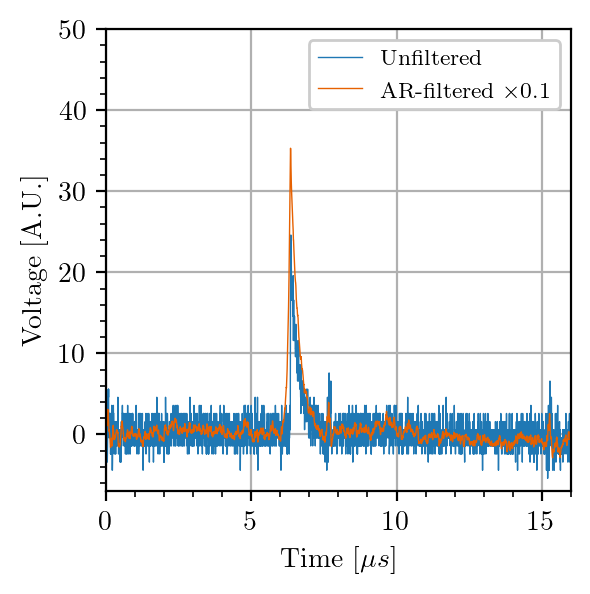

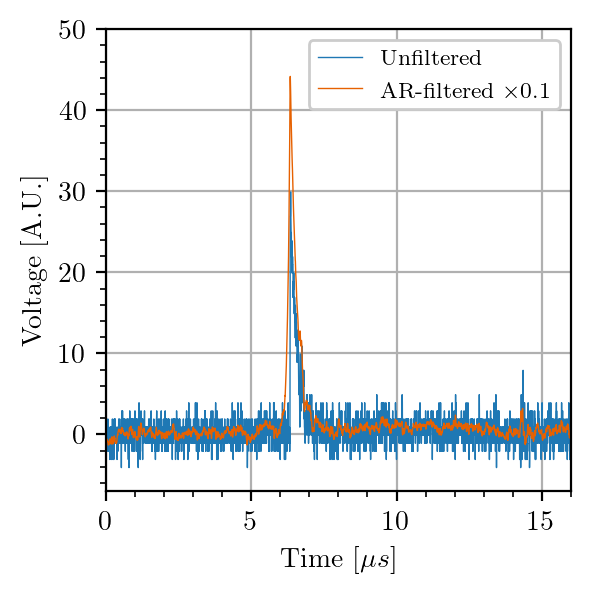

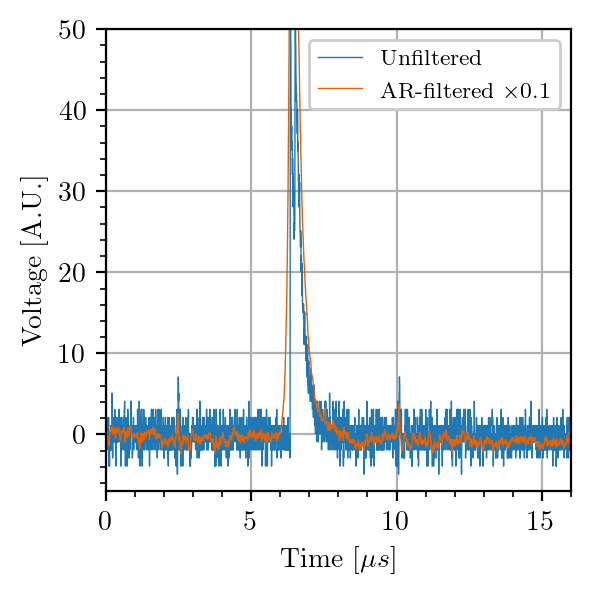

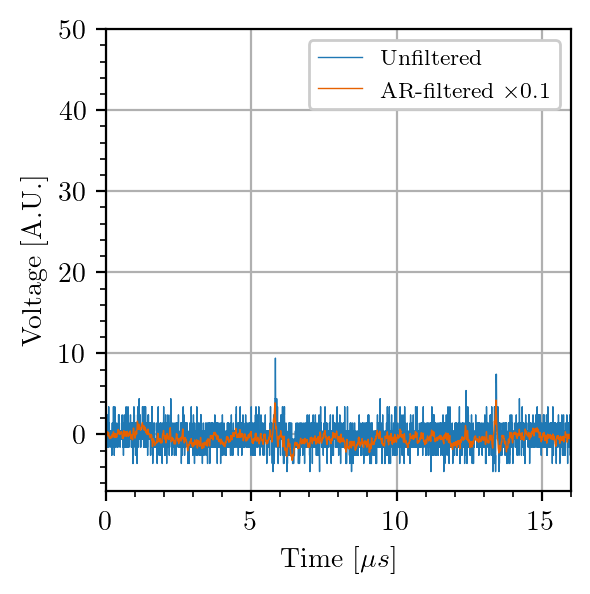

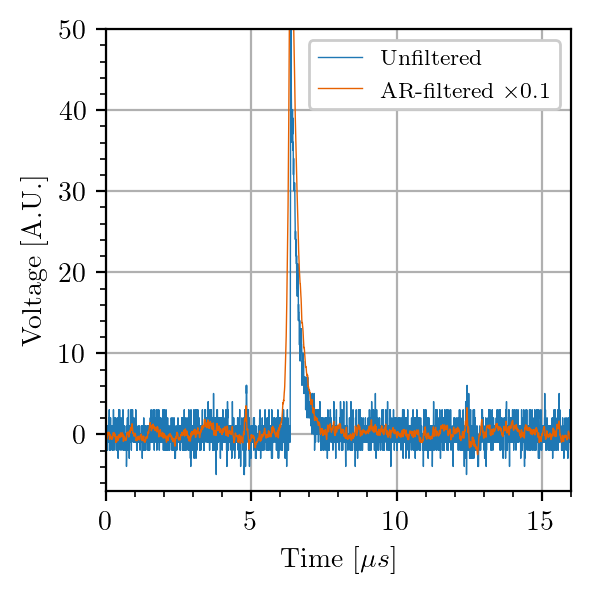

In [ ]:
import sipm.recon.WaveformDataset as wfd
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/'
direc = '2023-07-12/2023-07-12_volt_90_light_laser_config_1_cond_ln_intensity_1070/0/'
ch = 0
evid = np.arange(5, 10)
dset = wfd.WaveformDataset(path='{}{}'.format(
    data_dir, direc), pol=-1, channels=range(4))
wfs, arwfs = dset.ch[ch].get_waveforms(ev=evid, ar_filter=True)

for i, wf in enumerate(wfs):
    plt.figure(i, figsize=(3, 3))
    plt.plot(dset.ch[ch].time, wf, label='Unfiltered', linewidth=0.5)
    plt.plot(dset.ch[ch].time, arwfs[i]*0.1,
             label=r'AR-filtered $\times0.1$', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [A.U.]')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(0, 16)
    plt.ylim(-7, 50)

# Load pre-processed h5 files
These files should be processed by `exe/laser_pulse.py` script.

In [ ]:
intensities = [1070]
voltages = [90,92,94,96]
channels = [0,1,2,3]
directory = '/scratch/gpfs/as111/results/'
date = '2023-07-12'
verbose = True

metadata_dict = {}
for intn in intensities:
    metadata_dict[intn] = {}
    for ch in channels:
        metadata_dict[intn][ch] = {}
        for volt in voltages:
            metadata_dict[intn][ch][volt] = {'metadata':{
                'date':'2023-06-07',
                'volt': volt,
                'light': 'laser',
                'cond': f'ln_intensity_{intn}',
                'config': 1,
                'intensity': intn,
                'run': '*',
                'ch': ch
            }}
            files = glob.glob(f"{directory}{date}/{date}_volt_{volt}_light_laser_cond_ln_intensity_{intn}_config_1_intensity_{intn}_run*_laser_pulse.h5")
            data = []
            for f in files:
                ind = f.find('run')+3
                run_number = int(f[ind:f.find('_',ind)])
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                df['event'] = df.index
                df['run'] = np.array([run_number]*df.shape[0])
                data.append(df)
            if len(files)>0:
                data = pd.concat(data, ignore_index=True).sort_values(by=['run','event']).reset_index(drop=True)
            metadata_dict[intn][ch][volt]['data'] = data
            if verbose:
                if len(files)==0:
                    events = 0
                else:
                    keys = data.keys()
                    events = len(data[keys[0]])
                print(f'{date} {volt}V intensity={intn} ch{ch} - {len(files)} files {events} events')

2023-07-12 90V intensity=1070 ch0 - 5 files 104546 events
2023-07-12 92V intensity=1070 ch0 - 5 files 103918 events
2023-07-12 94V intensity=1070 ch0 - 5 files 103927 events
2023-07-12 96V intensity=1070 ch0 - 5 files 104054 events
2023-07-12 90V intensity=1070 ch1 - 5 files 104546 events
2023-07-12 92V intensity=1070 ch1 - 5 files 103918 events
2023-07-12 94V intensity=1070 ch1 - 5 files 103927 events
2023-07-12 96V intensity=1070 ch1 - 5 files 104054 events
2023-07-12 90V intensity=1070 ch2 - 5 files 104546 events
2023-07-12 92V intensity=1070 ch2 - 5 files 103918 events
2023-07-12 94V intensity=1070 ch2 - 5 files 103927 events
2023-07-12 96V intensity=1070 ch2 - 5 files 104054 events
2023-07-12 90V intensity=1070 ch3 - 5 files 104546 events
2023-07-12 92V intensity=1070 ch3 - 5 files 103918 events
2023-07-12 94V intensity=1070 ch3 - 5 files 103927 events
2023-07-12 96V intensity=1070 ch3 - 5 files 104054 events


## Baseline quality cut
To avoid pre-trigger pulses or abnormal fluctuations, we require that the RMS variation in the baseline region ($t<t_{\rm trigger}-0.5~\rm\mu s$) be less than $2.5$ ADC units.
This baseline cut normalizes the baseline mean distribution.
Cut fraction is around $0.1\%$ ($2\%$) for the top (bottom) tile.

In [ ]:
verbose = True
thre_ch = [2.,6.5,1.5,1.5]
mybsl = {}
for intn in intensities:
    mybsl[intn] = {}
    for ch in channels:
        mybsl[intn][ch] = {}
        for volt in voltages:
            mybsl[intn][ch][volt] = {'rms_threshold': thre_ch[ch]}
            data = metadata_dict[intn][ch][volt]['data']
            data['bsl_cut'] = data['baseline_rms']<mybsl[intn][ch][volt]['rms_threshold']
            rms_hist, rms_bins = np.histogram(data['baseline_rms'], bins=500, range=(0, 8))
            mean_hist, mean_bins = np.histogram(data['baseline_mean'], bins=1500, range=(3810, 3870))
            mean_hist_cut, mean_bins_cut = np.histogram(data['baseline_mean'].loc[data['bsl_cut']], bins=1500, range=(3800, 3900))
            cut_fraction = 1-np.sum(data['bsl_cut'])/data.shape[0]
            mybsl[intn][ch][volt].update({
                'rms_hist':rms_hist, 'rms_bins':rms_bins,
                'mean_hist':mean_hist, 'mean_bins':mean_bins,
                'mean_hist_cut':mean_hist_cut, 'mean_bins_cut':mean_bins_cut,
                'cut_fraction':cut_fraction
            })
            if verbose:
                print(f'{volt}V ch{ch} intensity={intn} cut fraction = {cut_fraction*100:.5f}%')
            

90V ch0 intensity=1070 cut fraction = 0.09852%
92V ch0 intensity=1070 cut fraction = 0.10970%
94V ch0 intensity=1070 cut fraction = 0.10007%
96V ch0 intensity=1070 cut fraction = 0.12205%
90V ch1 intensity=1070 cut fraction = 0.01435%
92V ch1 intensity=1070 cut fraction = 0.02021%
94V ch1 intensity=1070 cut fraction = 0.06062%
96V ch1 intensity=1070 cut fraction = 0.07784%
90V ch2 intensity=1070 cut fraction = 0.07365%
92V ch2 intensity=1070 cut fraction = 0.09623%
94V ch2 intensity=1070 cut fraction = 0.08949%
96V ch2 intensity=1070 cut fraction = 0.09803%
90V ch3 intensity=1070 cut fraction = 0.23913%
92V ch3 intensity=1070 cut fraction = 0.10874%
94V ch3 intensity=1070 cut fraction = 0.10007%
96V ch3 intensity=1070 cut fraction = 0.09706%


Text(0.07, 0.5, 'Count')

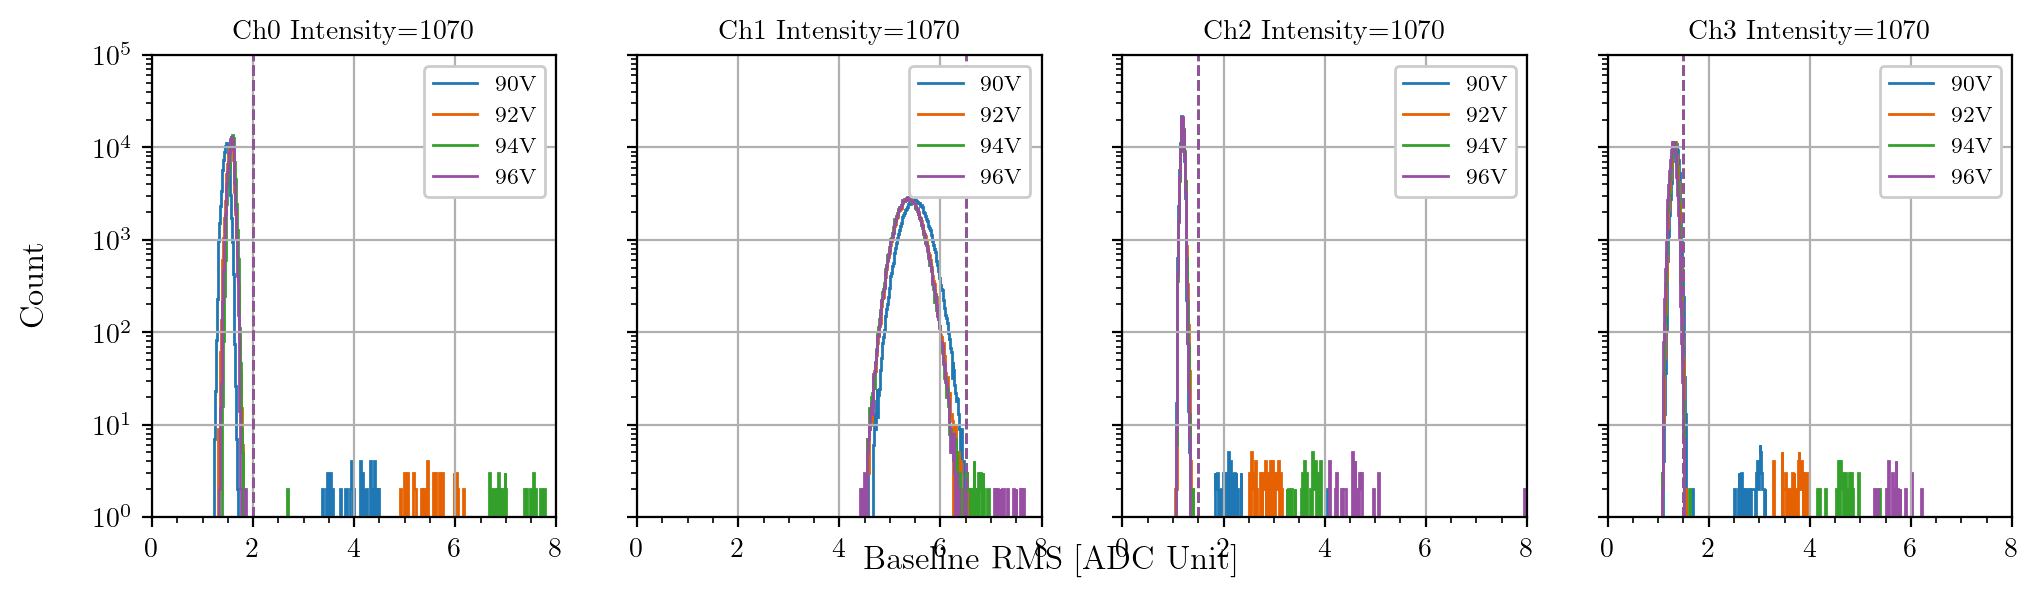

In [ ]:
# Make plots for all datasets
# Baseline RMS
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 3)
for i, intn in enumerate(intensities):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[j].stairs(mybsl[intn][ch][volt]['rms_hist'],
                             mybsl[intn][ch][volt]['rms_bins'],
                             label=f'{volt}V', color=f'C{k}')
            th = mybsl[intn][ch][volt]['rms_threshold']
            axs[j].plot([th, th], [1, 1e5], f'C{k}--', linewidth=1)
        axs[j].legend(loc='upper right')
        axs[j].set_ylim(1, 1e5)
        axs[j].set_yscale('log')
        axs[j].minorticks_on()
        axs[j].grid()
        axs[j].set_title(f'Ch{ch} Intensity={intn}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0.01)
fig.supylabel('Count', x=0.07)

Text(0.07, 0.5, 'Count')

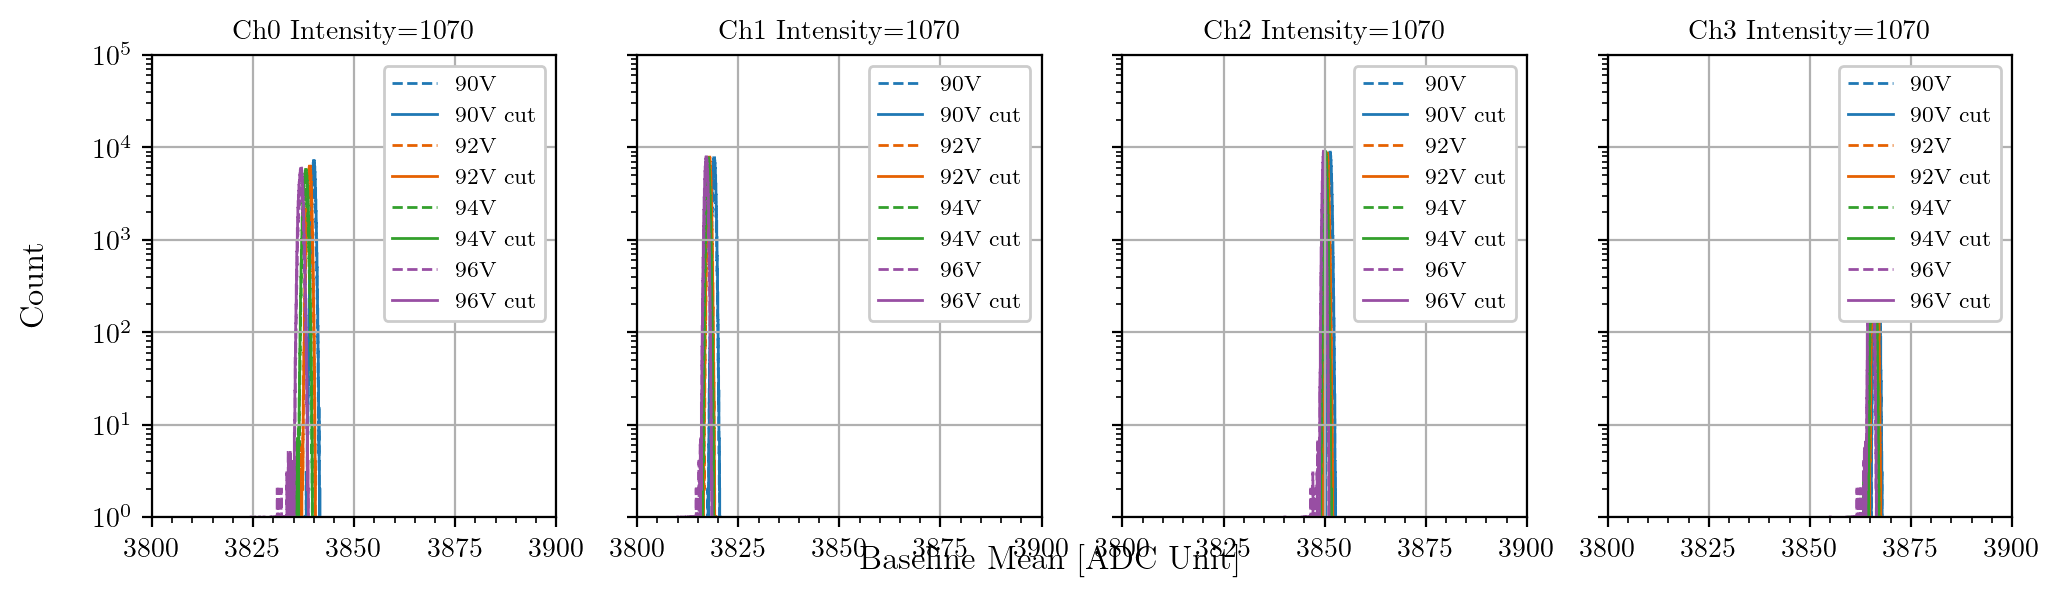

In [ ]:
# Make plots for all datasets
# Baseline mean
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 3)
for i, intn in enumerate(intensities):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[j].stairs(mybsl[intn][ch][volt]['mean_hist'],
                  mybsl[intn][ch][volt]['mean_bins'],
                  label=f'{volt}V', color=f'C{k}', linestyle='--')
            axs[j].stairs(mybsl[intn][ch][volt]['mean_hist_cut'],
                             mybsl[intn][ch][volt]['mean_bins_cut'],
                             label=f'{volt}V cut', color=f'C{k}')
        axs[j].legend(loc='upper right')
        axs[j].set_ylim(1, 1e5)
        axs[j].set_yscale('log')
        axs[j].minorticks_on()
        axs[j].grid()
        axs[j].set_title(f'Ch{ch} Intensity={intn}')
fig.supxlabel('Baseline Mean [ADC Unit]', y=0.01)
fig.supylabel('Count', x=0.07)

Plots for intensity=1070 ch3 90V


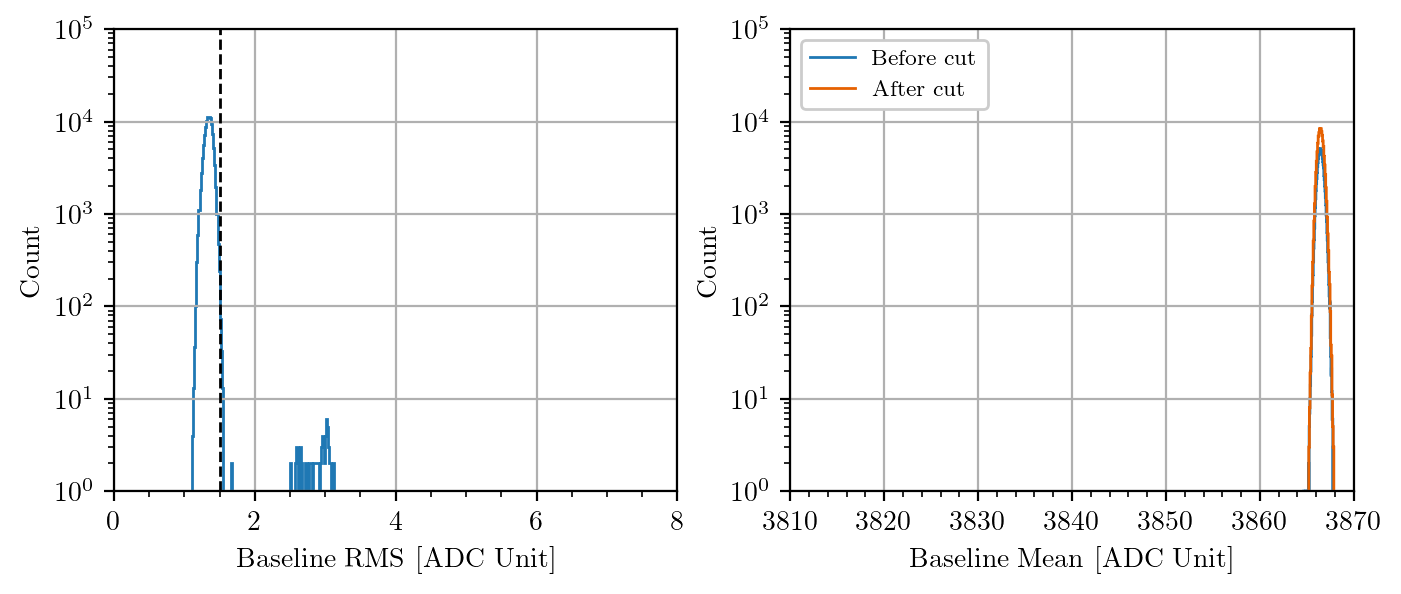

In [ ]:
# Make plots for selected dataset
intn = 1070
ch = 3
volt = 90
print(f'Plots for intensity={intn} ch{ch} {volt}V')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# rms
axs[0].stairs(mybsl[intn][ch][volt]['rms_hist'],
              mybsl[intn][ch][volt]['rms_bins'])
th = mybsl[intn][ch][volt]['rms_threshold']
axs[0].plot([th, th], [1, 1e5], 'k--', linewidth=1)
axs[0].set_ylim(1, 1e5)
axs[0].set_yscale('log')
axs[0].set_xlabel('Baseline RMS [ADC Unit]')
axs[0].set_ylabel('Count')
axs[0].minorticks_on()
axs[0].grid()

# mean
axs[1].stairs(mybsl[intn][ch][volt]['mean_hist'],
              mybsl[intn][ch][volt]['mean_bins'],
              label='Before cut')
axs[1].stairs(mybsl[intn][ch][volt]['mean_hist_cut'],
              mybsl[intn][ch][volt]['mean_bins_cut'],
              label='After cut')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylim(1, 1e5)
axs[1].set_xlim(mybsl[intn][ch][volt]['mean_bins'][0], mybsl[intn][ch][volt]['mean_bins'][-1])
axs[1].set_xlabel('Baseline Mean [ADC Unit]')
axs[1].set_ylabel('Count')
axs[1].minorticks_on()
axs[1].grid()

## Filtered amplitude & DiCT analysis
The PE peak positions are identified with ``scipy.signal.find_peaks``.
Let $A_k$ be the peak position of the $k$-PE peak (including $k=0$). 
The boundary between $k-1$ PEs and $k$ PEs is defined as $(A_{k-1}+A_{k})/2$.
The lower boundary of the 0th PE is $A_0-0.5(A_1-A_0)$ and similarly for the upper boundary of the highest identifiable PE.
One exception is bottom ch3 which has asymmetric peaks. See code for the modified boundary criterion.
The vertical dashed lines in the finger plots represent the boundaries.

Let $P_k$ be the fraction of events within the $k$-PE boundaries. 
It can be fitted by the [compound Poisson distribution](https://ieeexplore.ieee.org/document/5402300) describing a binomial chain process, with parameter $p$ being the DiCT probability and $\mu$ being the Poisson mean of primary PEs.

In [ ]:
boundary_par_dict = {}
amp_hist = {}
crosstalk = {}
nbins=2000
hist_range=(-5e2, 5e3)
bin_width = (hist_range[1]-hist_range[0])/nbins
prom,wid,dist=45,4,40
for intn in intensities:
    boundary_par_dict[intn] = {}
    amp_hist[intn] = {}
    crosstalk[intn] = {}
    for ch in channels:
        boundary_par_dict[intn][ch] = {}
        amp_hist[intn][ch] = {}
        crosstalk[intn][ch] = {}
        for volt in voltages:
            amp_hist[intn][ch][volt] = {}
            crosstalk[intn][ch][volt] = {}
            boundary_par_dict[intn][ch][volt] = 0.5
            nevents = np.sum(metadata_dict[intn][ch][volt]['data']['bsl_cut'])
            amp_hist[intn][ch][volt]['hist'], amp_hist[intn][ch][volt]['bins'] = np.histogram(
                metadata_dict[intn][ch][volt]['data']['amplitude_trig'].loc[metadata_dict[intn][ch][volt]['data']['bsl_cut']], 
                bins=nbins, range=hist_range
            )
            # find PE peaks in histogram
            p, pdict = scipy.signal.find_peaks(
                amp_hist[intn][ch][volt]['hist'], prominence=prom, width=wid, distance=dist)
            print(f'intensity={intn} {volt}V ch{ch} p=', p, ' prom=',pdict['prominences'], ' widths=', pdict['widths'])
            # discriminate different PE counts and calculate probability distribution P_k
            metadata_dict[intn][ch][volt]['data']['pe'] = np.zeros(metadata_dict[intn][ch][volt]['data'].shape[0]).astype(int)
            P_k = []
            npe = len(p)
            pe_cuts_in_bins = []
            bound_par = boundary_par_dict[intn][ch][volt]
            if npe>1:
                for ipe in range(npe):
                    if ipe == 0:
                        pe_cuts_in_bins.append(int(1.5*p[0]-0.5*p[1]))
                    else:
                        pe_cuts_in_bins.append(int(bound_par*p[ipe]+(1-bound_par)*p[ipe-1]))
                        metadata_dict[intn][ch][volt]['data']['pe'] += (metadata_dict[intn][ch][volt]['data']['amplitude_trig']>pe_cuts_in_bins[-1]*bin_width+hist_range[0]).astype(int)
                        P_k.append([np.sum(amp_hist[intn][ch][volt]['hist'][pe_cuts_in_bins[ipe-1]:pe_cuts_in_bins[ipe]])/nevents,
                                np.sqrt(np.sum(amp_hist[intn][ch][volt]['hist'][pe_cuts_in_bins[ipe-1]:pe_cuts_in_bins[ipe]]))/nevents])
            amp_hist[intn][ch][volt]['boundaries'] = list(
                np.array(pe_cuts_in_bins)*bin_width+hist_range[0])
            # Save P_k for Vinogradov fit
            if npe>1:
                crosstalk[intn][ch][volt]['y'] = np.array(P_k)[:, 0]
                crosstalk[intn][ch][volt]['yerr'] = np.array(P_k)[:, 1]
                crosstalk[intn][ch][volt]['x'] = np.arange(len(P_k))

intensity=1070 90V ch0 p= [179 320 463 611 758]  prom= [2266.  663.  488.  231.   96.]  widths= [ 5.95905696 49.70479303 51.3        59.36137821 57.68235294]
intensity=1070 92V ch0 p= [ 178  388  601  814 1014 1232]  prom= [1416.  497.  377.  216.  114.   54.]  widths= [ 7.62384028 51.94822283 59.48611111 69.92690058 71.15625    53.23214286]
intensity=1070 94V ch0 p= [ 174  442  738 1015 1312 1586]  prom= [1094.  377.  312.  217.  101.   53.]  widths= [ 8.90902612 54.08283283 57.46204934 65.59090909 79.1875     14.92329545]
intensity=1070 96V ch0 p= [ 172  501  878 1209 1574]  prom= [866. 312. 229. 147.  80.]  widths= [10.80357143 55.95833333 71.60887097 88.55681818 75.64285714]
intensity=1070 90V ch1 p= [191 279 380 473 574 670 761 852]  prom= [271. 463. 558. 518. 387. 259. 155.  69.]  widths= [12.94337607 22.7841074  29.82236842 34.52136752 35.89230769 36.190625
 31.35661765 32.60416667]
intensity=1070 92V ch1 p= [ 190  313  447  583  715  846  974 1121 1245]  prom= [215. 338. 418. 4

Text(0.07, 0.5, 'Count')

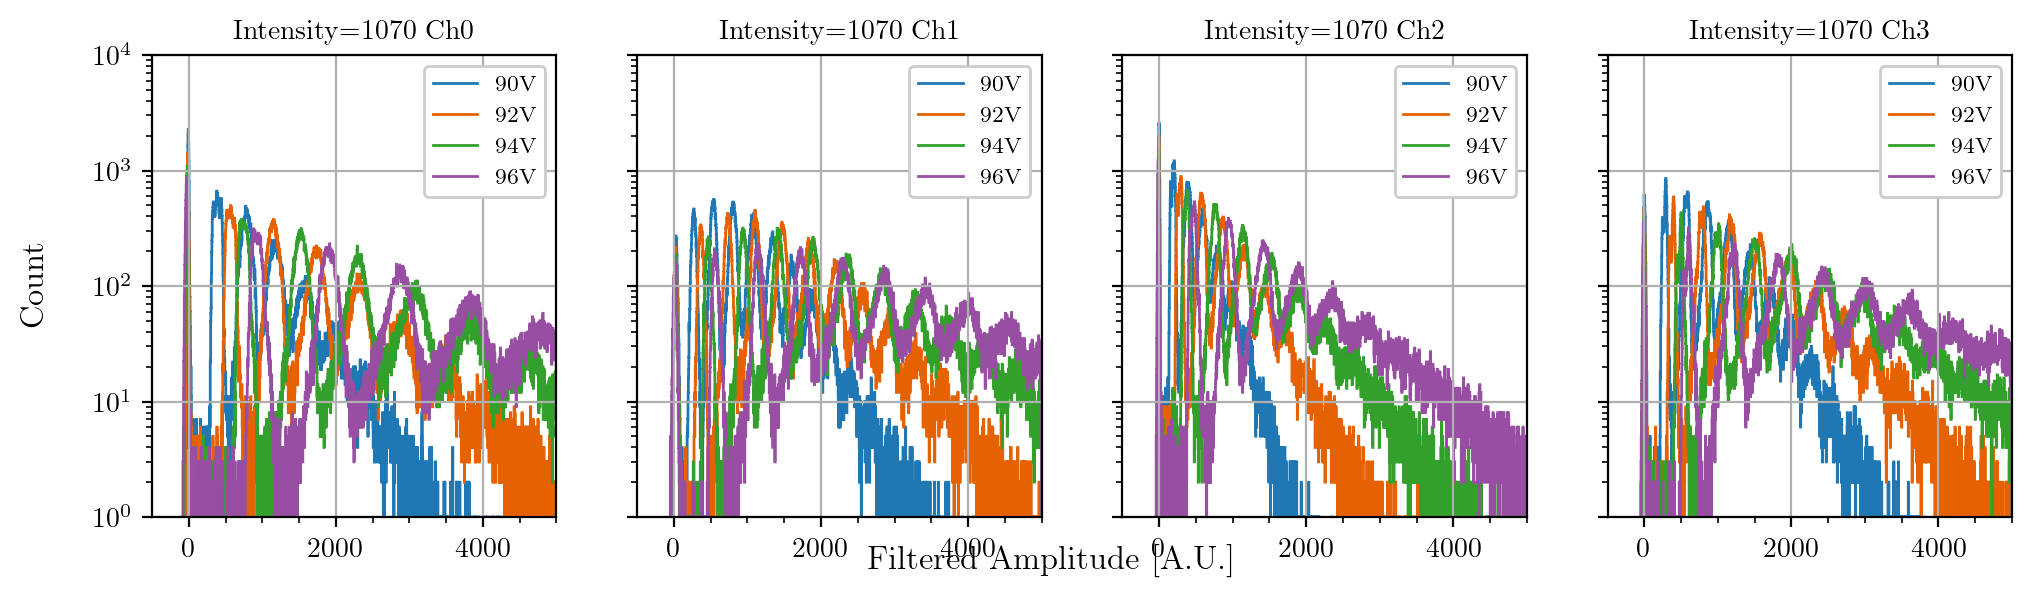

In [ ]:
# Make plots for all datasets
# Finger plots
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 3)
for i, intn in enumerate(intensities):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[j].stairs(amp_hist[intn][ch][volt]['hist'],
                             amp_hist[intn][ch][volt]['bins'],
                             label=f'{volt}V', color=f'C{k}')
        axs[j].legend(loc='upper right')
        axs[j].set_ylim(1, 1e4)
        axs[j].set_xlim(amp_hist[intn][ch][volt]['bins'][0],
                    amp_hist[intn][ch][volt]['bins'][-1])
        axs[j].set_yscale('log')
        axs[j].minorticks_on()
        axs[j].grid()
        axs[j].set_title(f'Intensity={intn} Ch{ch}')
fig.supxlabel('Filtered Amplitude [A.U.]', y=0.01)
fig.supylabel('Count', x=0.07)

In [ ]:
results = {'dict':{}}
for intn in intensities:
    results['dict'][intn] = {}
    for ch in channels:
        results['dict'][intn][ch] = {}
        for volt in voltages:
            # Do Vinogradov fit
            if 'x' in crosstalk[intn][ch][volt]:
                crosstalk[intn][ch][volt]['par'], crosstalk[intn][ch][volt]['cov'] = curve_fit(
                    func.compound_poisson,
                    crosstalk[intn][ch][volt]['x'],
                    crosstalk[intn][ch][volt]['y'],
                    p0=[2, 0.2], sigma=crosstalk[intn][ch][volt]['yerr'], maxfev=10000)
                # Save fit results
                crosstalk[intn][ch][volt]['dict'] = crosstalk[intn][ch][volt]['par'][1]
                crosstalk[intn][ch][volt]['dict_err'] = func.error_distance(df=2, sigma=1)*np.sqrt(crosstalk[intn][ch][volt]['cov'][1, 1])
                print(f'intensity={intn} ch{ch} {volt}V P_dict = {crosstalk[intn][ch][volt]["dict"]:.4f} +/- {crosstalk[intn][ch][volt]["dict_err"]:.4f}')
        results['dict'][intn][ch]['bias'] = voltages
        results['dict'][intn][ch]['dict'] = [crosstalk[intn][ch][volt]['dict'] for volt in voltages]
        results['dict'][intn][ch]['dict_err'] = [crosstalk[intn][ch][volt]['dict_err'] for volt in voltages]

intensity=1070 ch0 90V P_dict = 0.0536 +/- 0.0055
intensity=1070 ch0 92V P_dict = 0.1045 +/- 0.0060
intensity=1070 ch0 94V P_dict = 0.1634 +/- 0.0111
intensity=1070 ch0 96V P_dict = 0.2373 +/- 0.0047
intensity=1070 ch1 90V P_dict = 0.0929 +/- 0.0079
intensity=1070 ch1 92V P_dict = 0.1598 +/- 0.0069
intensity=1070 ch1 94V P_dict = 0.2110 +/- 0.0079
intensity=1070 ch1 96V P_dict = 0.2808 +/- 0.0064
intensity=1070 ch2 90V P_dict = 0.0573 +/- 0.0088
intensity=1070 ch2 92V P_dict = 0.1053 +/- 0.0105
intensity=1070 ch2 94V P_dict = 0.1621 +/- 0.0179
intensity=1070 ch2 96V P_dict = 0.2316 +/- 0.0029
intensity=1070 ch3 90V P_dict = 0.0790 +/- 0.0108
intensity=1070 ch3 92V P_dict = 0.1321 +/- 0.0100
intensity=1070 ch3 94V P_dict = 0.1775 +/- 0.0195
intensity=1070 ch3 96V P_dict = 0.2565 +/- 0.0089


Text(0.07, 0.5, 'Probability $P_k$')

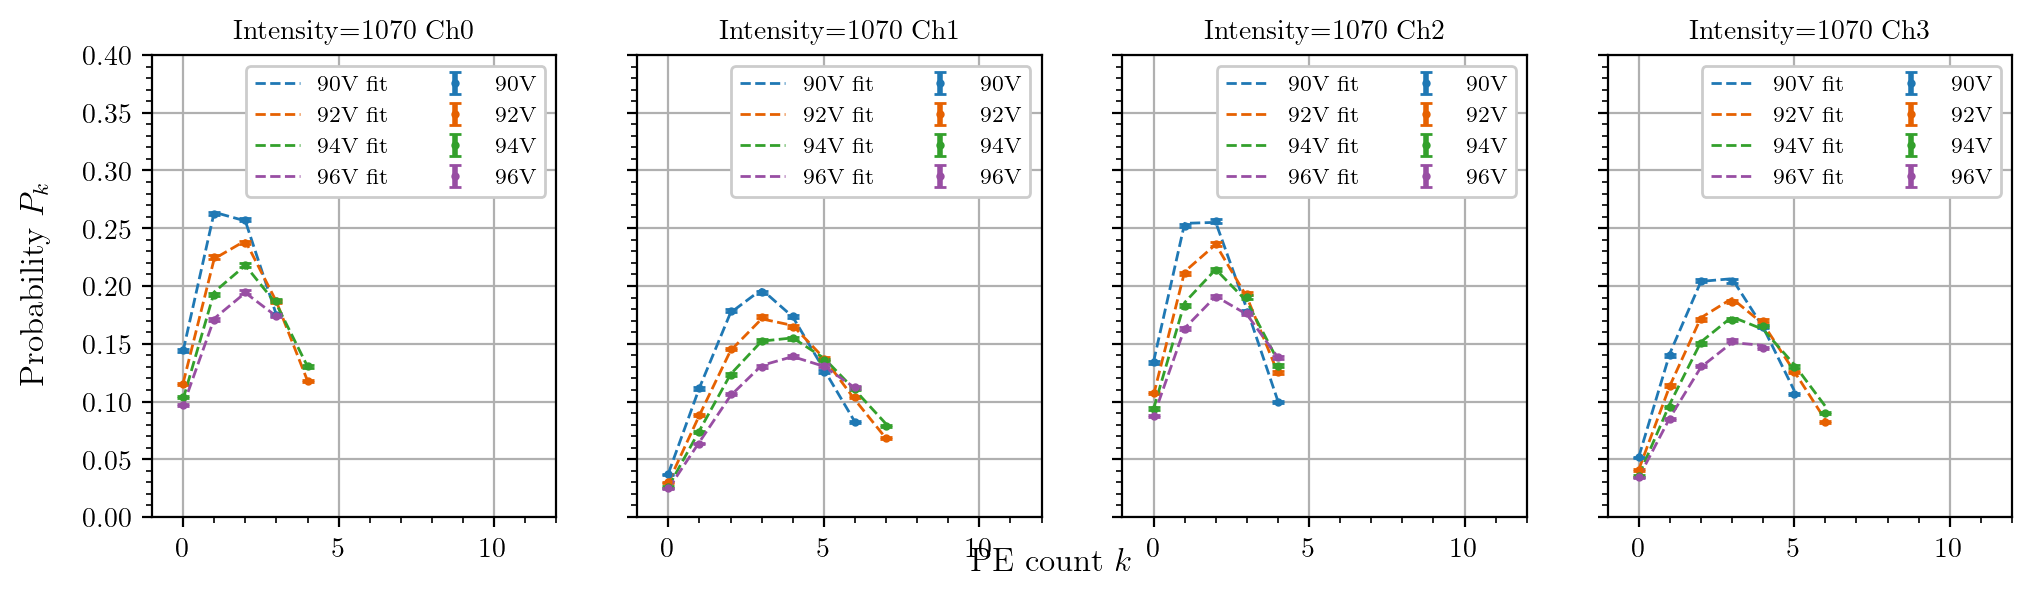

In [ ]:
# Make plots for all datasets
# DiCT fits
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 3)
for i, intn in enumerate(intensities):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            if 'x' in crosstalk[intn][ch][volt]:
                axs[j].errorbar(crosstalk[intn][ch][volt]['x'],
                     crosstalk[intn][ch][volt]['y'],
                     yerr=crosstalk[intn][ch][volt]['yerr'],
                     fmt=f'C{k}o', markersize=2, label=f'{volt}V')
                axs[j].plot(crosstalk[intn][ch][volt]['x'],
                            func.compound_poisson(
                                crosstalk[intn][ch][volt]['x'], *crosstalk[intn][ch][volt]['par']),
                            f'C{k}--', label=f'{volt}V fit', linewidth=1)
        axs[j].legend(loc='upper right', ncol=2)
        axs[j].set_ylim(0, 0.4)
        axs[j].set_xlim(-1, 12)
        axs[j].minorticks_on()
        axs[j].grid()
        axs[j].set_title(f'Intensity={intn} Ch{ch}')
fig.supxlabel(r'PE count $k$', y=0.01)
fig.supylabel(r'Probability $P_k$', x=0.07)

Plots for intensity=1070 ch3 96V


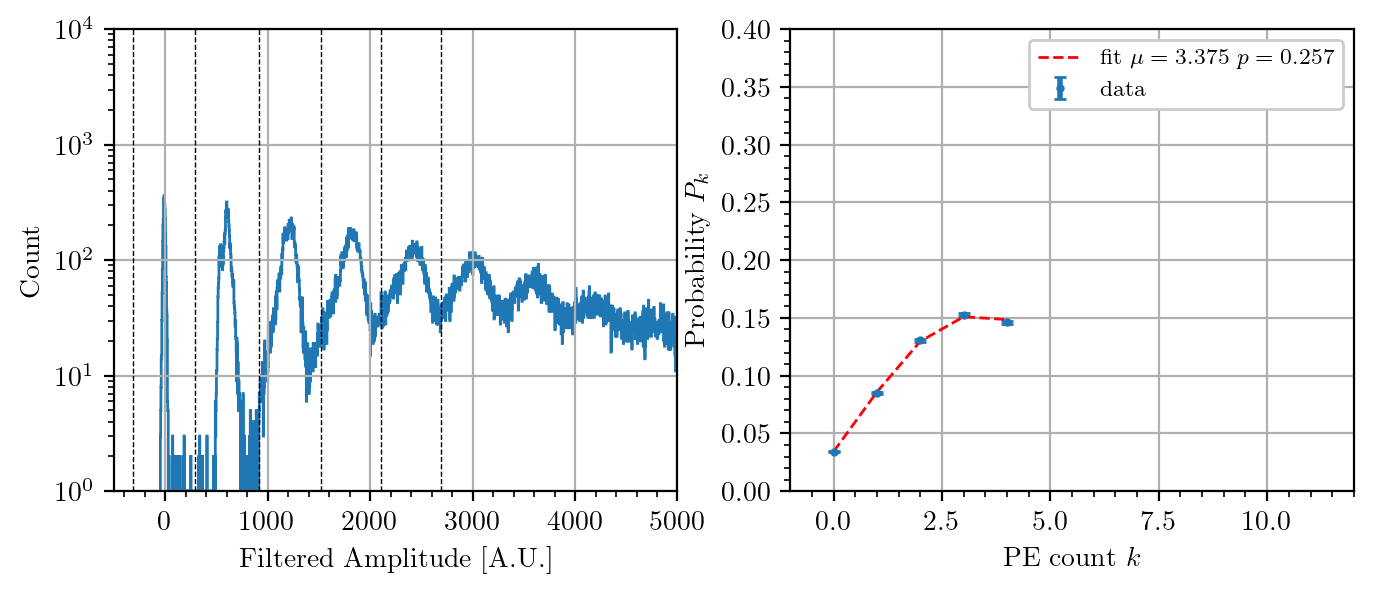

In [ ]:
# Make plots for selected datasets
intn = 1070
ch = 3
volt = 96
print(f'Plots for intensity={intn} ch{ch} {volt}V')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# filtered amplitude histogram
axs[0].stairs(amp_hist[intn][ch][volt]['hist'],
              amp_hist[intn][ch][volt]['bins'])
for b in amp_hist[intn][ch][volt]['boundaries']:
    axs[0].plot([b, b], [1, 1e4], 'k--', linewidth=0.5)
axs[0].set_yscale('log')
axs[0].set_xlabel('Filtered Amplitude [A.U.]')
axs[0].set_ylabel('Count')
axs[0].set_xlim(amp_hist[intn][ch][volt]['bins'][0],
                amp_hist[intn][ch][volt]['bins'][-1])
axs[0].set_ylim(1, 1e4)
axs[0].minorticks_on()
axs[0].grid()

# Vinogradov fit
axs[1].errorbar(crosstalk[intn][ch][volt]['x'],
                crosstalk[intn][ch][volt]['y'],
                yerr=crosstalk[intn][ch][volt]['yerr'],
                fmt='o', markersize=2, label='data')
axs[1].plot(crosstalk[intn][ch][volt]['x'],
            func.compound_poisson(
                crosstalk[intn][ch][volt]['x'], *crosstalk[intn][ch][volt]['par']),
            'r--', label=r'fit $\mu={:.3f}$ $p={:.3f}$'.format(*crosstalk[intn][ch][volt]['par']), linewidth=1)
axs[1].set_xlabel(r'PE count $k$')
axs[1].set_ylabel(r'Probability $P_k$')
axs[1].set_ylim(0, 0.4)
axs[1].set_xlim(-1, 12)
axs[1].legend(loc='upper right')
axs[1].minorticks_on()
axs[1].grid()

# Integrated charge and afterpulsing analysis
The integral window is $5~\rm\mu s$ post-trigger and $0.5~\rm \mu s$ pre-trigger.
The integrals are grouped by the PE counts $k$ defined with the filtered amplitude (see previous cell).
The integral distribution has a Gaussian left tail but a heavier right tail due to afterpulses.
The part of the histograms near the peak is fitted by a Gaussian PDF to find the peak position, denoted by $I_{k,\rm peak}$.
$I_{k,\rm peak}$ is linear with $k$, and the slope $Q_{\rm peak}$ is the SPE gain of the SiPMs in arbitrary units.<br>

The average of the histogram, excluding overflowing bins (to reject scintillation events that have very high charge integrals), is denoted by $I_{k,\rm avg}$.
It is also linear with $k$, and the slope is denoted by $Q_{\rm avg}$.
The relative difference, $\frac{Q_{\rm avg}}{Q_{\rm peak}}-1$, is the average afterpulse charge per PE enhanced by DiCT.
Therefore, we define the afterpulse charge as $Q_{\rm AP}=(\frac{Q_{\rm avg}}{Q_{\rm peak}}-1)(1-p)$.<br>

The afterpulse *probability* is also estimated using the fraction of events under the Gaussian (i.e. the normalization of Gaussian function) out of total events.
This fraction is the probability that all $k$ cells have no afterpulse, denoted by $1-P_{\rm AP}(k)$. It should equal to $(1-P_{\rm AP})^k$, where $P_{\rm AP}$ is the afterpulse probability per PE.
$P_{\rm AP}$ extracted from the fits are consistent with $Q_{\rm AP}$, indicating that most afterpulses are a full PE.

The breakdown voltage is obtained by a linear fit to $Q_{\rm peak}$ as a function of bias $V$ using $Q_{\rm peak}=C(V-V_{\rm bd})$.
A comparison of breakdown voltage across channels is further down in the notebook.

In [ ]:
charge_hist = {}
charge_fits = {}
ap_prob = {}
fit_range_thre = (0.02, 0.45)
hist_range = (-2e3, 1.6e4)
nbins = 1000
for intn in intensities:
    charge_hist[intn] = {}
    charge_fits[intn] = {}
    ap_prob[intn] = {}
    for ch in channels:
        charge_hist[intn][ch] = {}
        charge_fits[intn][ch] = {}
        ap_prob[intn][ch] = {}
        for volt in voltages:
            charge_hist[intn][ch][volt] = {}
            charge_fits[intn][ch][volt] = {}
            ap_prob[intn][ch][volt] = {}
            range_min = hist_range[0]
            range_max = hist_range[1]+(volt-90)*1e3
            bin_width = (range_max-range_min)/nbins
            for pe in np.arange(1,len(amp_hist[intn][ch][volt]['boundaries'])-1):
                charge_hist[intn][ch][volt][pe] = {}
                charge_fits[intn][ch][volt][pe] = {}
                ap_prob[intn][ch][volt][pe] = {}
                # Generate histograms
                selected_charges = metadata_dict[intn][ch][volt]['data']['integral_5p00us'].loc[(metadata_dict[intn][ch][volt]['data']['bsl_cut'])&(metadata_dict[intn][ch][volt]['data']['pe']==pe)&(metadata_dict[intn][ch][volt]['data']['integral_5p00us']<range_max)&(metadata_dict[intn][ch][volt]['data']['integral_5p00us']>range_min)]
                charge_hist[intn][ch][volt][pe]['hist'], charge_hist[intn][ch][volt][pe]['bins'] = np.histogram(
                    selected_charges, bins=nbins, range=(range_min, range_max))
                # find appropriate fit range
                peak_bin = np.argmax(charge_hist[intn][ch][volt][pe]['hist'])
                fit_min = peak_bin
                while charge_hist[intn][ch][volt][pe]['hist'][fit_min] > fit_range_thre[0]*charge_hist[intn][ch][volt][pe]['hist'][peak_bin]:
                    fit_min -= 1
                if charge_hist[intn][ch][volt][pe]['hist'][fit_min] == 0:
                    fit_min += 1
                charge_fits[intn][ch][volt][pe]['min_bin'] = fit_min
                fit_max = peak_bin
                while charge_hist[intn][ch][volt][pe]['hist'][fit_max] > fit_range_thre[1]*charge_hist[intn][ch][volt][pe]['hist'][peak_bin]:
                    fit_max += 1
                if charge_hist[intn][ch][volt][pe]['hist'][fit_max] == 0:
                    fit_max -= 1
                charge_fits[intn][ch][volt][pe]['max_bin'] = fit_max
                # Gaussian fits
                charge_fits[intn][ch][volt][pe]['par'], charge_fits[intn][ch][volt][pe]['cov'] = curve_fit(
                    func.gauss_normalized,
                    0.5*(charge_hist[intn][ch][volt][pe]['bins'][fit_min:fit_max]+charge_hist[intn][ch][volt][pe]['bins'][fit_min+1:fit_max+1]),
                    charge_hist[intn][ch][volt][pe]['hist'][fit_min:fit_max],
                    p0=[charge_hist[intn][ch][volt][pe]['hist'][peak_bin]*(fit_max-fit_min)*bin_width/3,
                        peak_bin*bin_width+range_min,
                        (fit_max-fit_min)*bin_width/3],
                    sigma=np.sqrt(charge_hist[intn][ch][volt][pe]['hist'][fit_min:fit_max]),
                    maxfev=100000)
                # Store peak positions and averages
                charge_fits[intn][ch][volt][pe]['Ipeak'] = charge_fits[intn][ch][volt][pe]['par'][1]
                charge_fits[intn][ch][volt][pe]['Ipeak_err'] = func.error_distance(
                    df=3, sigma=1)*np.sqrt(charge_fits[intn][ch][volt][pe]['cov'][1, 1])
                charge_fits[intn][ch][volt][pe]['Iavg'] = np.mean(selected_charges)
                charge_fits[intn][ch][volt][pe]['Iavg_err'] = np.std(selected_charges)/np.sqrt(len(selected_charges))
                # Store afterpulse probability
                ap_prob[intn][ch][volt][pe]['prob'] = charge_fits[intn][ch][volt][pe]['par'][0]/bin_width/len(selected_charges)
                ap_prob[intn][ch][volt][pe]['prob_err'] = np.sqrt(ap_prob[intn][ch][volt][pe]['prob']*(1-ap_prob[intn][ch][volt][pe]['prob'])/len(selected_charges))


Text(0.07, 0.5, 'Count')

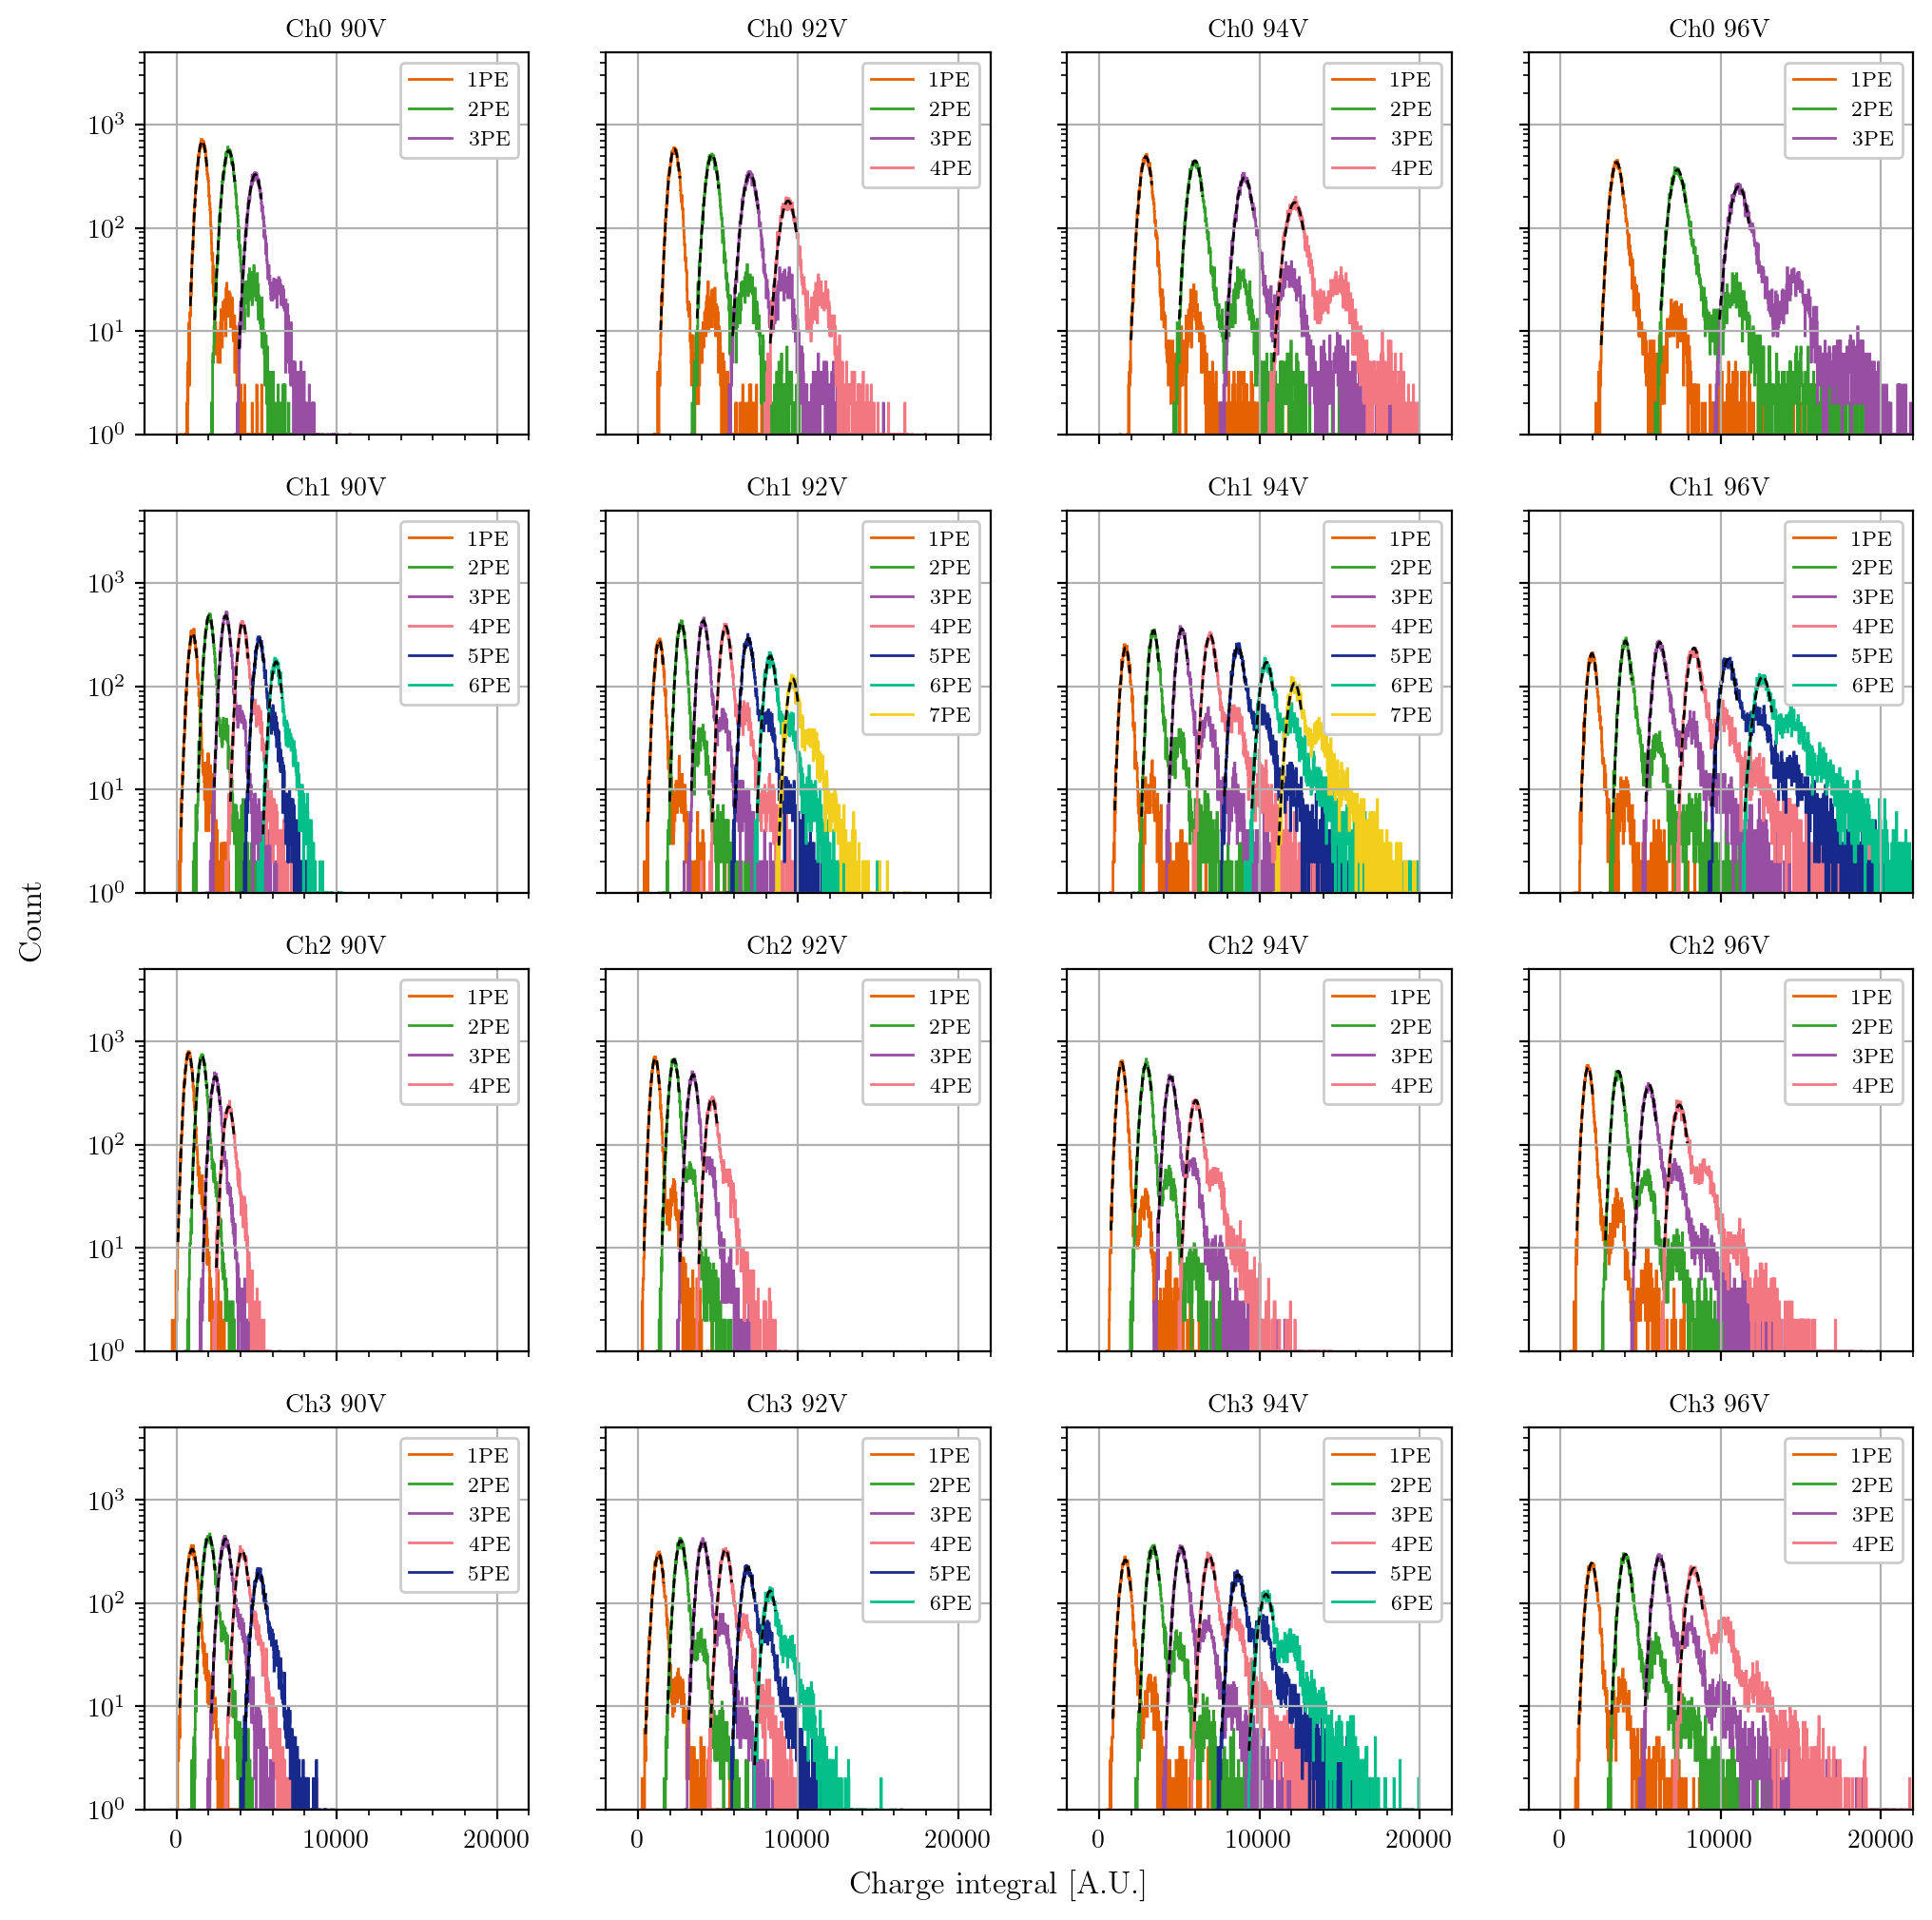

In [ ]:
# Make plots for all datasets
# Charge histograms
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
for i, intn in enumerate(intensities):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            for pe in charge_hist[intn][ch][volt].keys():
                axs[i*4+j, k].stairs(charge_hist[intn][ch][volt][pe]['hist'],
                                     charge_hist[intn][ch][volt][pe]['bins'], label=f'{pe}PE', color=f'C{pe}')
                fit_min = charge_fits[intn][ch][volt][pe]['min_bin']
                fit_max = charge_fits[intn][ch][volt][pe]['max_bin']
                axs[i*4+j, k].plot(charge_hist[intn][ch][volt][pe]['bins'][fit_min:fit_max], func.gauss_normalized(
                    charge_hist[intn][ch][volt][pe]['bins'][fit_min:fit_max], *charge_fits[intn][ch][volt][pe]['par']), f'k--', linewidth=1)
            axs[i*4+j, k].legend(loc='upper right')
            axs[i*4+j, k].set_ylim(1, 5e3)
            xmin = charge_hist[intn][ch][volt][list(
                charge_hist[intn][ch][volt].keys())[-1]]['bins'][0]
            xmax = charge_hist[intn][ch][volt][list(
                charge_hist[intn][ch][volt].keys())[-1]]['bins'][-1]
            axs[i*4+j, k].set_xlim(xmin, xmax)
            axs[i*4+j, k].set_yscale('log')
            axs[i*4+j, k].minorticks_on()
            axs[i*4+j, k].grid()
            axs[i*4+j,
                k].set_title(f'Ch{ch} {volt}V')
fig.supxlabel(r'Charge integral [A.U.]', y=0.07)
fig.supylabel(r'Count', x=0.07)

In [ ]:
gain_peak_fits = {}
gain_avg_fits = {}
results['gain'] = {}
for intn in intensities:
    gain_peak_fits[intn] = {}
    gain_avg_fits[intn] = {}
    results['gain'][intn] = {}
    for ch in channels:
        gain_peak_fits[intn][ch] = {}
        gain_avg_fits[intn][ch] = {}
        results['gain'][intn][ch] = {}
        for volt in voltages:
            gain_peak_fits[intn][ch][volt] = {}
            gain_avg_fits[intn][ch][volt] = {}
            # Qpeak fit
            gain_peak_fits[intn][ch][volt]['x'] = np.array(list(charge_fits[intn][ch][volt].keys()))
            gain_peak_fits[intn][ch][volt]['y'] = np.array([charge_fits[intn][ch][volt][pe]['Ipeak'] for pe in charge_fits[intn][ch][volt].keys()])
            gain_peak_fits[intn][ch][volt]['yerr'] = np.array([charge_fits[intn][ch][volt][pe]['Ipeak_err'] for pe in charge_fits[intn][ch][volt].keys()])
            gain_peak_fits[intn][ch][volt]['par'], gain_peak_fits[intn][ch][volt]['cov'] = curve_fit(
                func.line_simple,
                gain_peak_fits[intn][ch][volt]['x'],
                gain_peak_fits[intn][ch][volt]['y'],
                sigma=gain_peak_fits[intn][ch][volt]['yerr'],
                p0=[500, 0],
                maxfev=10000)
            gain_peak_fits[intn][ch][volt]['Qpeak'] = gain_peak_fits[intn][ch][volt]['par'][0]
            gain_peak_fits[intn][ch][volt]['Qpeak_err'] = func.error_distance(df=2, sigma=1)*np.sqrt(gain_peak_fits[intn][ch][volt]['cov'][0, 0])
            # Qavg fit
            gain_avg_fits[intn][ch][volt]['x'] = np.array(list(charge_fits[intn][ch][volt].keys()))
            gain_avg_fits[intn][ch][volt]['y'] = np.array([charge_fits[intn][ch][volt][pe]['Iavg'] for pe in charge_fits[intn][ch][volt].keys()])
            gain_avg_fits[intn][ch][volt]['yerr'] = np.array([charge_fits[intn][ch][volt][pe]['Iavg_err'] for pe in charge_fits[intn][ch][volt].keys()])
            gain_avg_fits[intn][ch][volt]['par'], gain_avg_fits[intn][ch][volt]['cov'] = curve_fit(
                func.line_simple,
                gain_avg_fits[intn][ch][volt]['x'],
                gain_avg_fits[intn][ch][volt]['y'],
                sigma=gain_avg_fits[intn][ch][volt]['yerr'],
                p0=[500, 0],
                maxfev=10000)
            gain_avg_fits[intn][ch][volt]['Qavg'] = gain_avg_fits[intn][ch][volt]['par'][0]
            gain_avg_fits[intn][ch][volt]['Qavg_err'] = func.error_distance(df=2, sigma=1)*np.sqrt(gain_avg_fits[intn][ch][volt]['cov'][0, 0])
        results['gain'][intn][ch]['bias'] = voltages
        results['gain'][intn][ch]['gain'] = [gain_peak_fits[intn][ch][volt]['Qpeak'] for volt in voltages]
        results['gain'][intn][ch]['gain_err'] = [gain_peak_fits[intn][ch][volt]['Qpeak_err'] for volt in voltages]

Text(0.07, 0.5, 'Charge integral $I_k$ [A.U.]')

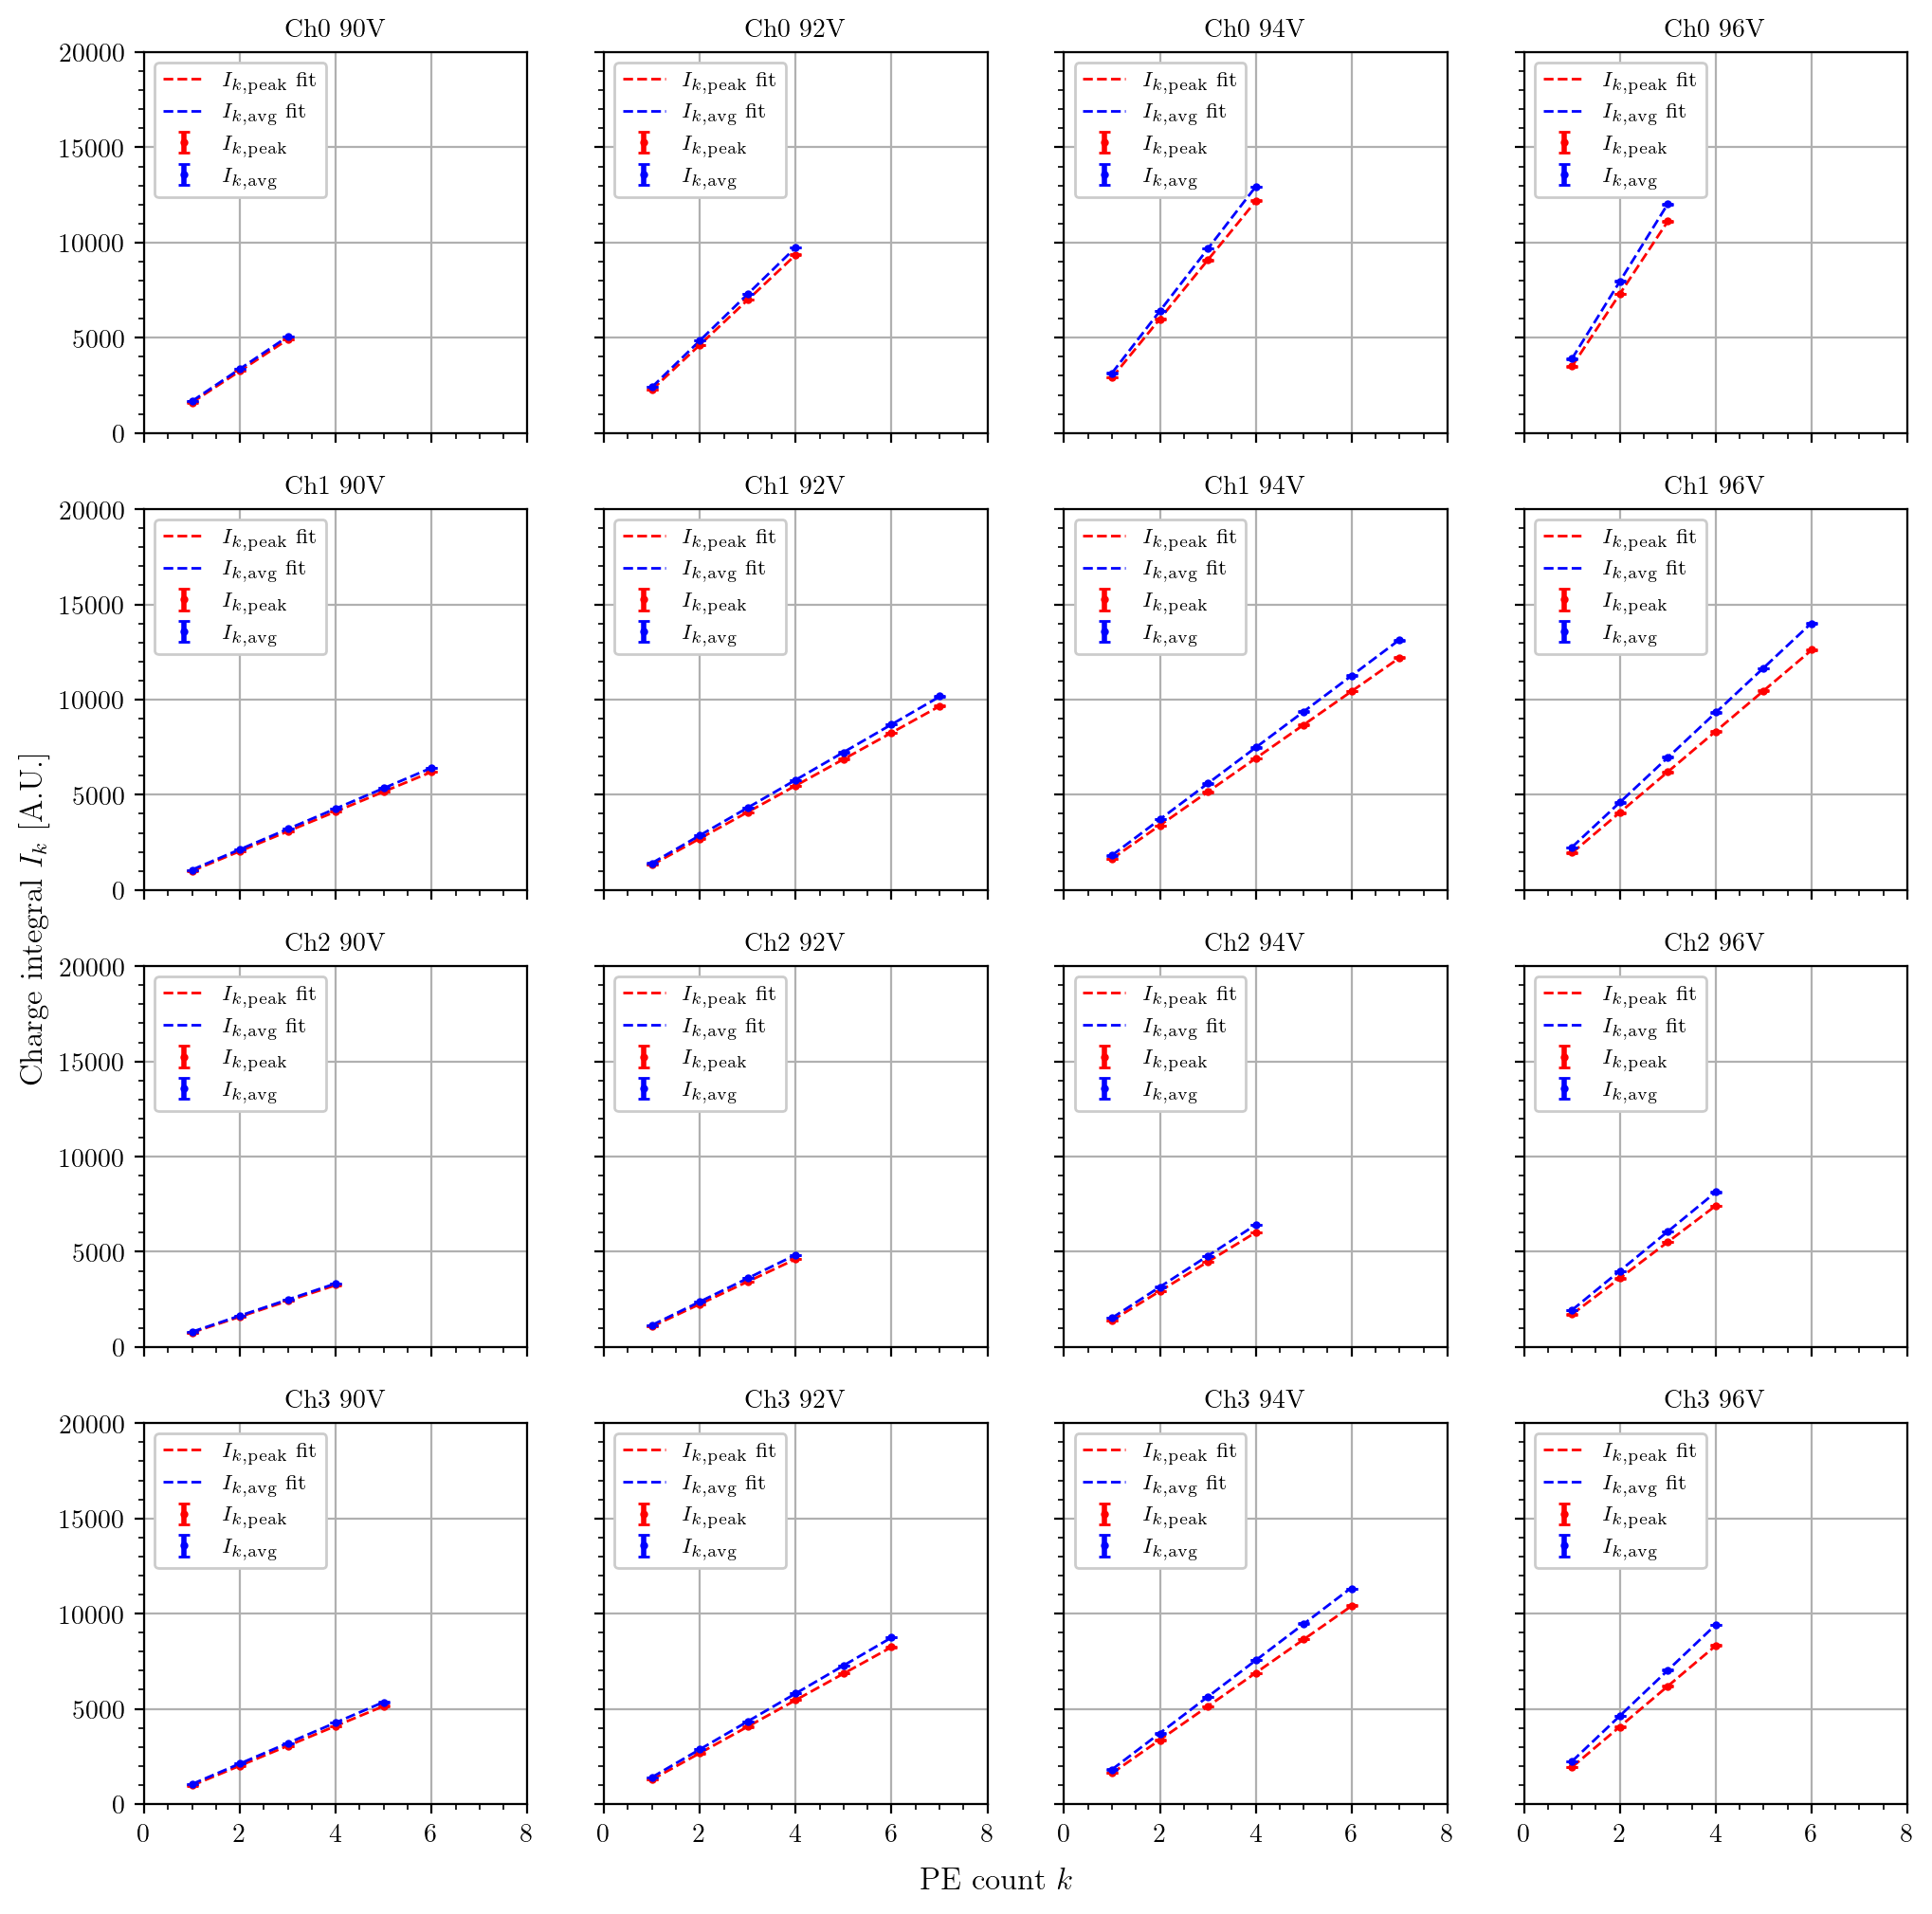

In [ ]:
# Make plots for all datasets
# Charge-PE fits
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
for j, ch in enumerate(channels):
    for k, volt in enumerate(voltages):
        axs[j, k].errorbar(gain_peak_fits[intn][ch][volt]['x'], gain_peak_fits[intn][ch][volt]['y'],
                                yerr=gain_peak_fits[intn][ch][volt]['yerr'], fmt='ro', markersize=2, label=r'$I_{k,\rm peak}$')
        axs[j, k].plot(gain_peak_fits[intn][ch][volt]['x'], func.line_simple(gain_peak_fits[intn][ch][volt]
                            ['x'], *gain_peak_fits[intn][ch][volt]['par']), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        axs[j, k].errorbar(gain_avg_fits[intn][ch][volt]['x'], gain_avg_fits[intn][ch][volt]['y'],
                                yerr=gain_avg_fits[intn][ch][volt]['yerr'], fmt='bo', markersize=2, label=r'$I_{k,\rm avg}$')
        axs[j, k].plot(gain_avg_fits[intn][ch][volt]['x'], func.line_simple(gain_avg_fits[intn][ch][volt]
                            ['x'], *gain_avg_fits[intn][ch][volt]['par']), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        axs[j, k].legend(loc='upper left')
        axs[j, k].set_ylim(0, 2e4)
        axs[j, k].set_xlim(0, 8)
        axs[j, k].minorticks_on()
        axs[j, k].grid()
        axs[j, k].set_title(f'Ch{ch} {volt}V')
fig.supxlabel(r'PE count $k$', y=0.07)
fig.supylabel(r'Charge integral $I_k$ [A.U.]', x=0.07)

In [ ]:
ap_charge = {}
ap_prob_fits = {}
results['ap_charge'] = {}
results['ap_prob'] = {}
for intn in intensities:
    ap_charge[intn] = {}
    ap_prob_fits[intn] = {}
    results['ap_charge'][intn] = {}
    results['ap_prob'][intn] = {}
    for ch in channels:
        ap_charge[intn][ch] = {}
        ap_prob_fits[intn][ch] = {}
        results['ap_charge'][intn][ch] = {}
        results['ap_prob'][intn][ch] = {}
        for volt in voltages:
            ap_charge[intn][ch][volt] = {}
            ap_prob_fits[intn][ch][volt] = {}
            # Afterpulse charge
            ap_charge[intn][ch][volt]['Qap'] = gain_avg_fits[intn][ch][volt]['Qavg']/gain_peak_fits[intn][ch][volt]['Qpeak'] - 1
            ap_charge[intn][ch][volt]['Qap_err'] = (1+ap_charge[intn][ch][volt]['Qap'])*np.sqrt((gain_avg_fits[intn][ch][volt]['Qavg_err']/gain_avg_fits[intn][ch][volt]['Qavg'])**2+(gain_peak_fits[intn][ch][volt]['Qpeak_err']/gain_peak_fits[intn][ch][volt]['Qpeak'])**2)
            ap_charge[intn][ch][volt]['Qap'] *= 1-crosstalk[intn][ch][volt]['dict']  # correct for APxDiCT
            ap_charge[intn][ch][volt]['Qap_err'] *= 1-crosstalk[intn][ch][volt]['dict']  # correct for APxDiCT
            # Afterpulse probability fit
            ap_prob_fits[intn][ch][volt]['x'] = np.array(list(ap_prob[intn][ch][volt].keys()))
            ap_prob_fits[intn][ch][volt]['y'] = [ap_prob[intn][ch][volt][pe]['prob'] for pe in ap_prob[intn][ch][volt].keys()]
            ap_prob_fits[intn][ch][volt]['yerr'] = [ap_prob[intn][ch][volt][pe]['prob_err'] for pe in ap_prob[intn][ch][volt].keys()]
            ap_prob_fits[intn][ch][volt]['par'], ap_prob_fits[intn][ch][volt]['cov'] = curve_fit(
                func.power,
                ap_prob_fits[intn][ch][volt]['x'],
                ap_prob_fits[intn][ch][volt]['y'],
                sigma=ap_prob_fits[intn][ch][volt]['yerr'],
                p0=[0.9],
                maxfev=10000)
            ap_prob_fits[intn][ch][volt]['Pap'] = 1-ap_prob_fits[intn][ch][volt]['par'][0]
            ap_prob_fits[intn][ch][volt]['Pap_err'] = func.error_distance(df=1, sigma=1)*np.sqrt(ap_prob_fits[intn][ch][volt]['cov'][0, 0])
        # Qap-Vbias
        results['ap_charge'][intn][ch]['bias'] = voltages
        results['ap_charge'][intn][ch]['ap_charge'] = [ap_charge[intn][ch][volt]['Qap'] for volt in voltages]
        results['ap_charge'][intn][ch]['ap_charge_err'] = [ap_charge[intn][ch][volt]['Qap_err'] for volt in voltages]
        # Pap-Vbias
        results['ap_prob'][intn][ch]['bias'] = voltages
        results['ap_prob'][intn][ch]['ap_prob'] = [ap_prob_fits[intn][ch][volt]['Pap'] for volt in voltages]
        results['ap_prob'][intn][ch]['ap_prob_err'] = [ap_prob_fits[intn][ch][volt]['Pap_err'] for volt in voltages]

Text(0.03, 0.5, '$1-P_{\\rm AP}(k)$')

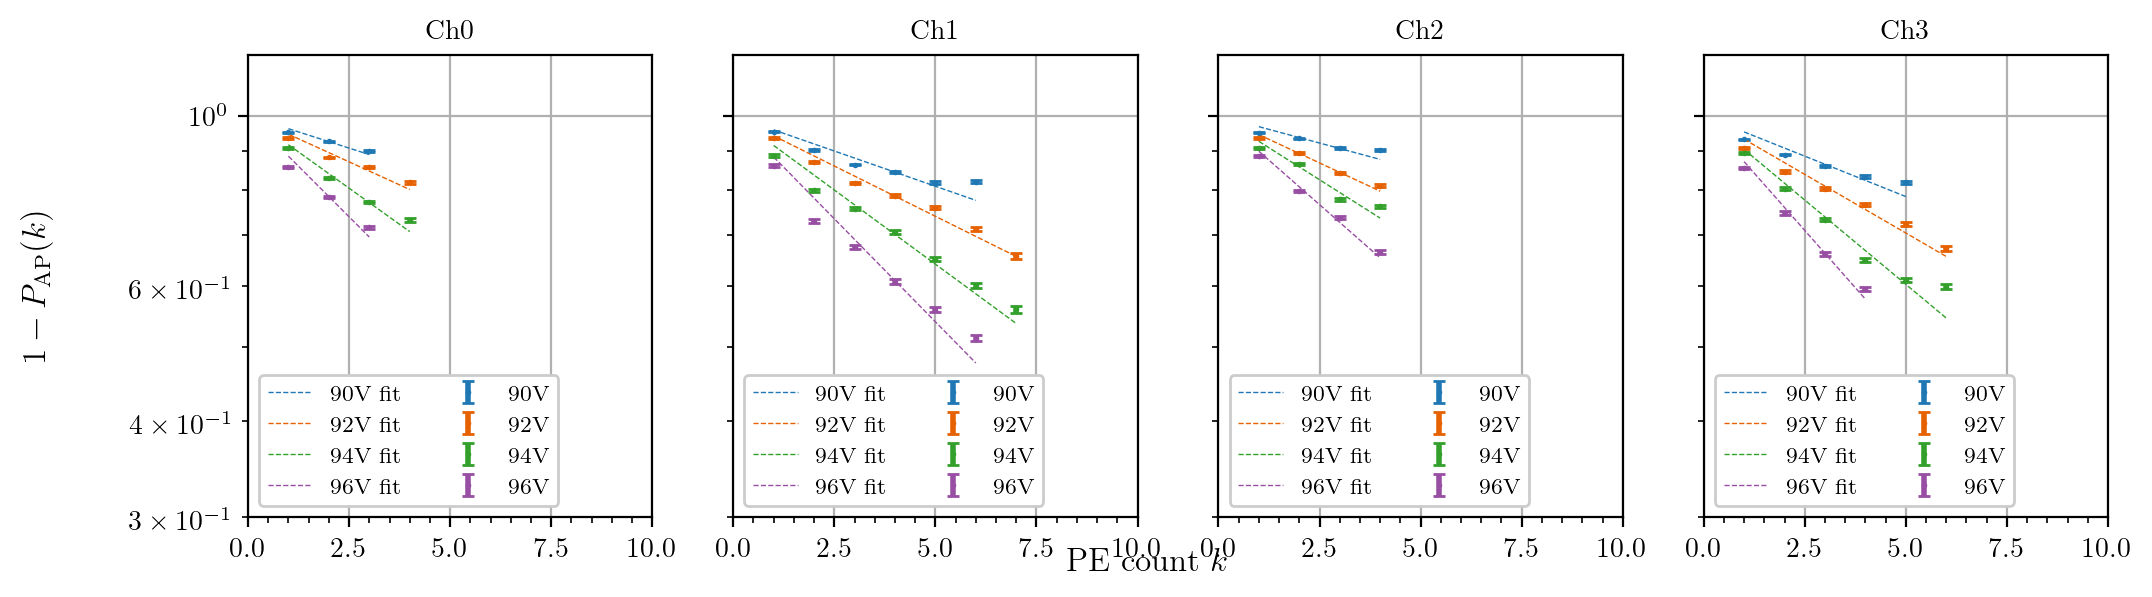

In [ ]:
# Make plots for all datasets
# Afterpulse probability fits
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 3)
intn = 1070
for j, ch in enumerate(channels):
    for k, volt in enumerate(voltages):
        axs[j].errorbar(ap_prob_fits[intn][ch][volt]['x'], ap_prob_fits[intn][ch][volt]['y'],
                            yerr=ap_prob_fits[intn][ch][volt]['yerr'], fmt=f'C{k}o', markersize=1, label=f'{volt}V')
        axs[j].plot(ap_prob_fits[intn][ch][volt]['x'], func.power(ap_prob_fits[intn][ch][volt]['x'],
                        *ap_prob_fits[intn][ch][volt]['par']), f'C{k}--', linewidth=0.5, label=f'{volt}V fit')
    axs[j].legend(loc='lower left', ncol=2)
    axs[j].set_ylim(0.3, 1.2)
    axs[j].set_xlim(0, 10)
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Ch{ch}')
fig.supxlabel(r'PE count $k$', y=0.01)
fig.supylabel(r'$1-P_{\rm AP}(k)$', x=0.03)

Plots for ch3 94V


(0.0, 1.0, 0.0, 1.0)

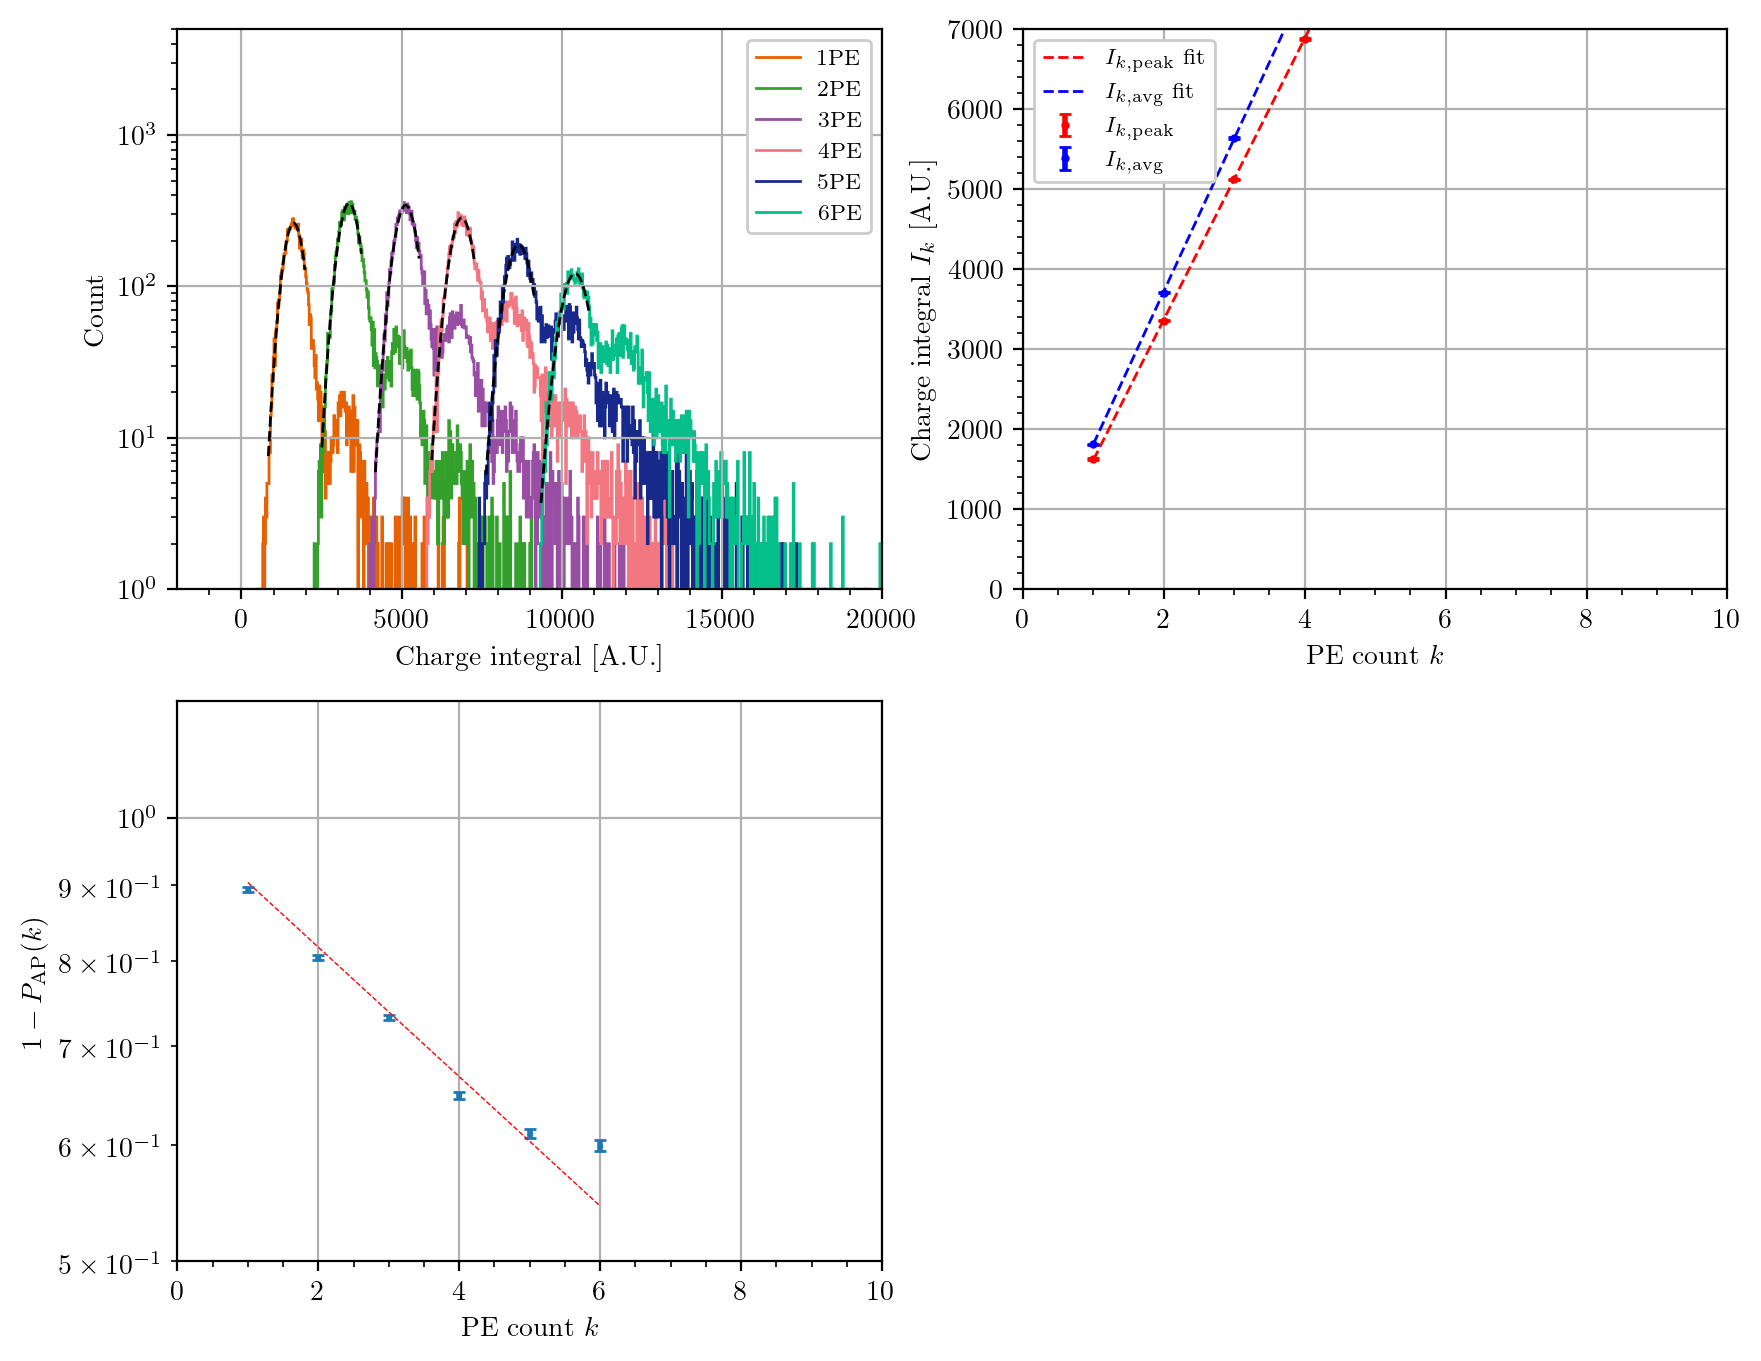

In [ ]:
# Make plots for selected datasets
intn = 1070
ch = 3
volt = 94
print(f'Plots for ch{ch} {volt}V')
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 8)

# charge histograms
for pe in charge_hist[intn][ch][volt].keys():
    axs[0, 0].stairs(charge_hist[intn][ch][volt][pe]['hist'],
                     charge_hist[intn][ch][volt][pe]['bins'], label=f'{pe}PE', color=f'C{pe}')
    fit_min = charge_fits[intn][ch][volt][pe]['min_bin']
    fit_max = charge_fits[intn][ch][volt][pe]['max_bin']
    axs[0, 0].plot(charge_hist[intn][ch][volt][pe]['bins'][fit_min:fit_max], func.gauss_normalized(
        charge_hist[intn][ch][volt][pe]['bins'][fit_min:fit_max], *charge_fits[intn][ch][volt][pe]['par']), f'k--', linewidth=1)
axs[0, 0].legend(loc='upper right')
axs[0, 0].set_ylim(1, 5e3)
xmin = charge_hist[intn][ch][volt][list(
    charge_hist[intn][ch][volt].keys())[-1]]['bins'][0]
xmax = charge_hist[intn][ch][volt][list(
    charge_hist[intn][ch][volt].keys())[-1]]['bins'][-1]
axs[0, 0].set_xlim(xmin, xmax)
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel(r'Charge integral [A.U.]')
axs[0, 0].set_ylabel(r'Count')
axs[0, 0].minorticks_on()
axs[0, 0].grid()

# charge-pe linear fits
axs[0, 1].errorbar(gain_peak_fits[intn][ch][volt]['x'], gain_peak_fits[intn][ch][volt]['y'],
                   yerr=gain_peak_fits[intn][ch][volt]['yerr'], fmt='ro', markersize=2, label=r'$I_{k,\rm peak}$')
axs[0, 1].plot(gain_peak_fits[intn][ch][volt]['x'], func.line_simple(gain_peak_fits[intn][ch][volt]
               ['x'], *gain_peak_fits[intn][ch][volt]['par']), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
axs[0, 1].errorbar(gain_avg_fits[intn][ch][volt]['x'], gain_avg_fits[intn][ch][volt]['y'],
                   yerr=gain_avg_fits[intn][ch][volt]['yerr'], fmt='bo', markersize=2, label=r'$I_{k,\rm avg}$')
axs[0, 1].plot(gain_avg_fits[intn][ch][volt]['x'], func.line_simple(gain_avg_fits[intn][ch][volt]
               ['x'], *gain_avg_fits[intn][ch][volt]['par']), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
axs[0, 1].legend()
axs[0, 1].set_xlabel(r'PE count $k$')
axs[0, 1].set_ylabel(r'Charge integral $I_k$ [A.U.]')
axs[0, 1].set_xlim(0, 10)
axs[0, 1].set_ylim(0, 7e3)
axs[0, 1].legend()
axs[0, 1].grid()
axs[0, 1].minorticks_on()

# afterpulse probability
axs[1, 0].errorbar(ap_prob_fits[intn][ch][volt]['x'],
                   ap_prob_fits[intn][ch][volt]['y'],
                   yerr=ap_prob_fits[intn][ch][volt]['yerr'],
                   fmt='o',
                   markersize=1)
axs[1, 0].plot(ap_prob_fits[intn][ch][volt]['x'],
               func.power(ap_prob_fits[intn][ch][volt]['x'],
                          *ap_prob_fits[intn][ch][volt]['par']),
               'r--',
               linewidth=0.5)
axs[1, 0].set_xlim(0, 10)
axs[1, 0].set_ylim(0.5, 1.2)
axs[1, 0].set_yscale('log')
axs[1, 0].minorticks_on()
axs[1, 0].grid()
axs[1, 0].set_xlabel(r'PE count $k$')
axs[1, 0].set_ylabel(r'$1-P_{\rm AP}(k)$')

# empty figure
axs[1, 1].axis('off')

In [ ]:
nsipms = 2
vbd_fits = {}
results['vbd'] = {}
init_pars=[100,55]
for intn in intensities:
    vbd_fits[intn] = {}
    results['vbd'][intn] = {}
    for ch in channels:
        vbd_fits[intn][ch] = {}
        results['vbd'][intn][ch] = {}
        vbd_fits[intn][ch]['x'] = voltages
        vbd_fits[intn][ch]['y'] = [gain_peak_fits[intn][ch][volt]['Qpeak'] for volt in voltages]
        vbd_fits[intn][ch]['yerr'] = [gain_peak_fits[intn][ch][volt]['Qpeak_err'] for volt in voltages]
        vbd_fits[intn][ch]['par'], vbd_fits[intn][ch]['cov'] = curve_fit(
            func.line,
            vbd_fits[intn][ch]['x'],
            vbd_fits[intn][ch]['y'],
            sigma=vbd_fits[intn][ch]['yerr'],
            p0=init_pars,
            maxfev=10000)
        vbd_fits[intn][ch]['vbd'] = vbd_fits[intn][ch]['par'][1]
        vbd_fits[intn][ch]['vbd_err'] = func.error_distance(df=2, sigma=1)*np.sqrt(vbd_fits[intn][ch]['cov'][1, 1])
        print(f'ch{ch} Vbd = {vbd_fits[intn][ch]["vbd"]:.2f} +/- {vbd_fits[intn][ch]["vbd_err"]:.2f} V')
        results['vbd'][intn][ch]['vbd_sipm'] = vbd_fits[intn][ch]['vbd']/nsipms
        results['vbd'][intn][ch]['vbd_sipm_err'] = vbd_fits[intn][ch]['vbd_err']/nsipms
        results['dict'][intn][ch]['ov'] = np.array(results['dict'][intn][ch]['bias'])/nsipms-results['vbd'][intn][ch]['vbd_sipm']
        results['dict'][intn][ch]['ov_err'] = np.ones(results['dict'][intn][ch]['ov'].shape[0])*results['vbd'][intn][ch]['vbd_sipm_err']
        results['ap_charge'][intn][ch]['ov'] = np.array(results['ap_charge'][intn][ch]['bias'])/nsipms-results['vbd'][intn][ch]['vbd_sipm']
        results['ap_charge'][intn][ch]['ov_err'] = np.ones(results['ap_charge'][intn][ch]['ov'].shape[0])*results['vbd'][intn][ch]['vbd_sipm_err']
        results['ap_prob'][intn][ch]['ov'] = np.array(results['ap_prob'][intn][ch]['bias'])/nsipms-results['vbd'][intn][ch]['vbd_sipm']
        results['ap_prob'][intn][ch]['ov_err'] = np.ones(results['ap_prob'][intn][ch]['ov'].shape[0])*results['vbd'][intn][ch]['vbd_sipm_err']
        results['gain'][intn][ch]['ov'] = np.array(results['gain'][intn][ch]['bias'])/nsipms-results['vbd'][intn][ch]['vbd_sipm']
        results['gain'][intn][ch]['ov_err'] = np.ones(results['gain'][intn][ch]['ov'].shape[0])*results['vbd'][intn][ch]['vbd_sipm_err']

ch0 Vbd = 85.38 +/- 0.02 V
ch1 Vbd = 84.25 +/- 0.14 V
ch2 Vbd = 85.36 +/- 0.07 V
ch3 Vbd = 84.22 +/- 0.12 V


(0.0, 5000.0)

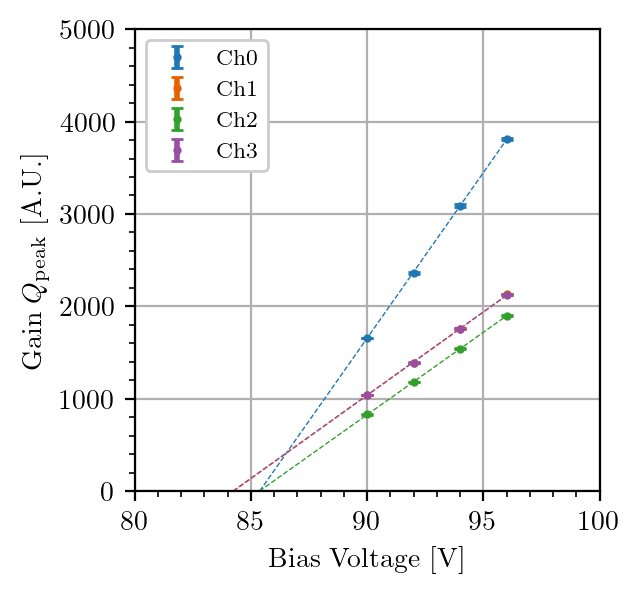

In [ ]:
# Make plots for all datasets
# Gain-Vbias linear fits
fig, ax = plt.subplots(1)
fig.set_size_inches(3, 3)
for intn in intensities:
    for ch in channels:
        ax.errorbar(vbd_fits[intn][ch]['x'],
                    vbd_fits[intn][ch]['y'],
                    yerr=vbd_fits[intn][ch]['yerr'],
                    label=f'Ch{ch}', fmt='C{}o'.format(ch), markersize=2)
        ax.plot(sorted(voltages + [vbd_fits[intn][ch]['vbd']]),
                func.line(np.array(sorted(voltages + [vbd_fits[intn][ch]['vbd']])), *vbd_fits[intn][ch]['par']),
                '--', linewidth=0.5)
ax.legend(loc='upper left')
ax.set_xlabel('Bias Voltage [V]')
ax.set_ylabel(r'Gain $Q_{\rm peak}$ [A.U.]')
ax.grid()
ax.minorticks_on()
ax.set_xlim(80, 100)
ax.set_ylim(0, 5.0e3)


Plots for ch3


(0.0, 5000.0)

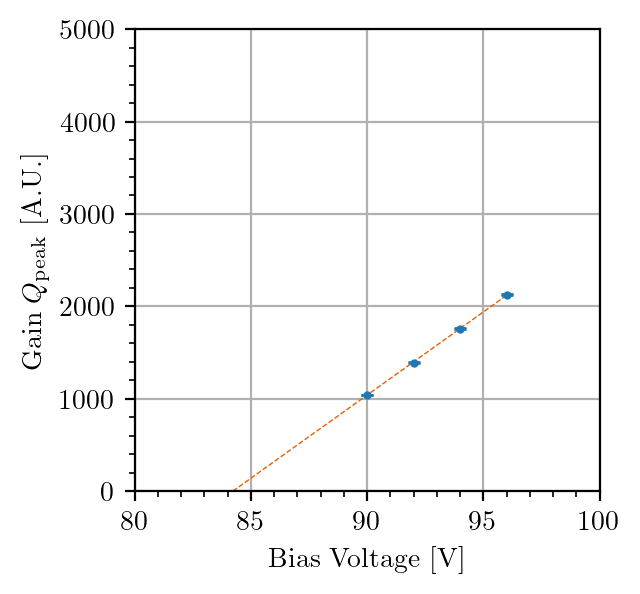

In [ ]:
# Make plots for selected datasets
intn = 1070
ch = 3
print(f'Plots for ch{ch}')
fig, ax = plt.subplots(1)
fig.set_size_inches(3, 3)
# Gain-Vbias linear fits
ax.errorbar(vbd_fits[intn][ch]['x'],
            vbd_fits[intn][ch]['y'],
            yerr=vbd_fits[intn][ch]['yerr'],
            label=f'ch{ch}', fmt='o', markersize=2)
ax.plot(sorted(voltages + [vbd_fits[intn][ch]['vbd']]),
        func.line(np.array(sorted(voltages + [vbd_fits[intn][ch]['vbd']])), *vbd_fits[intn][ch]['par']),
        '--', linewidth=0.5)
ax.set_xlabel('Bias Voltage [V]')
ax.set_ylabel(r'Gain $Q_{\rm peak}$ [A.U.]')
ax.grid()
ax.minorticks_on()
ax.set_xlim(80, 100)
ax.set_ylim(0, 5e3)


# Summary

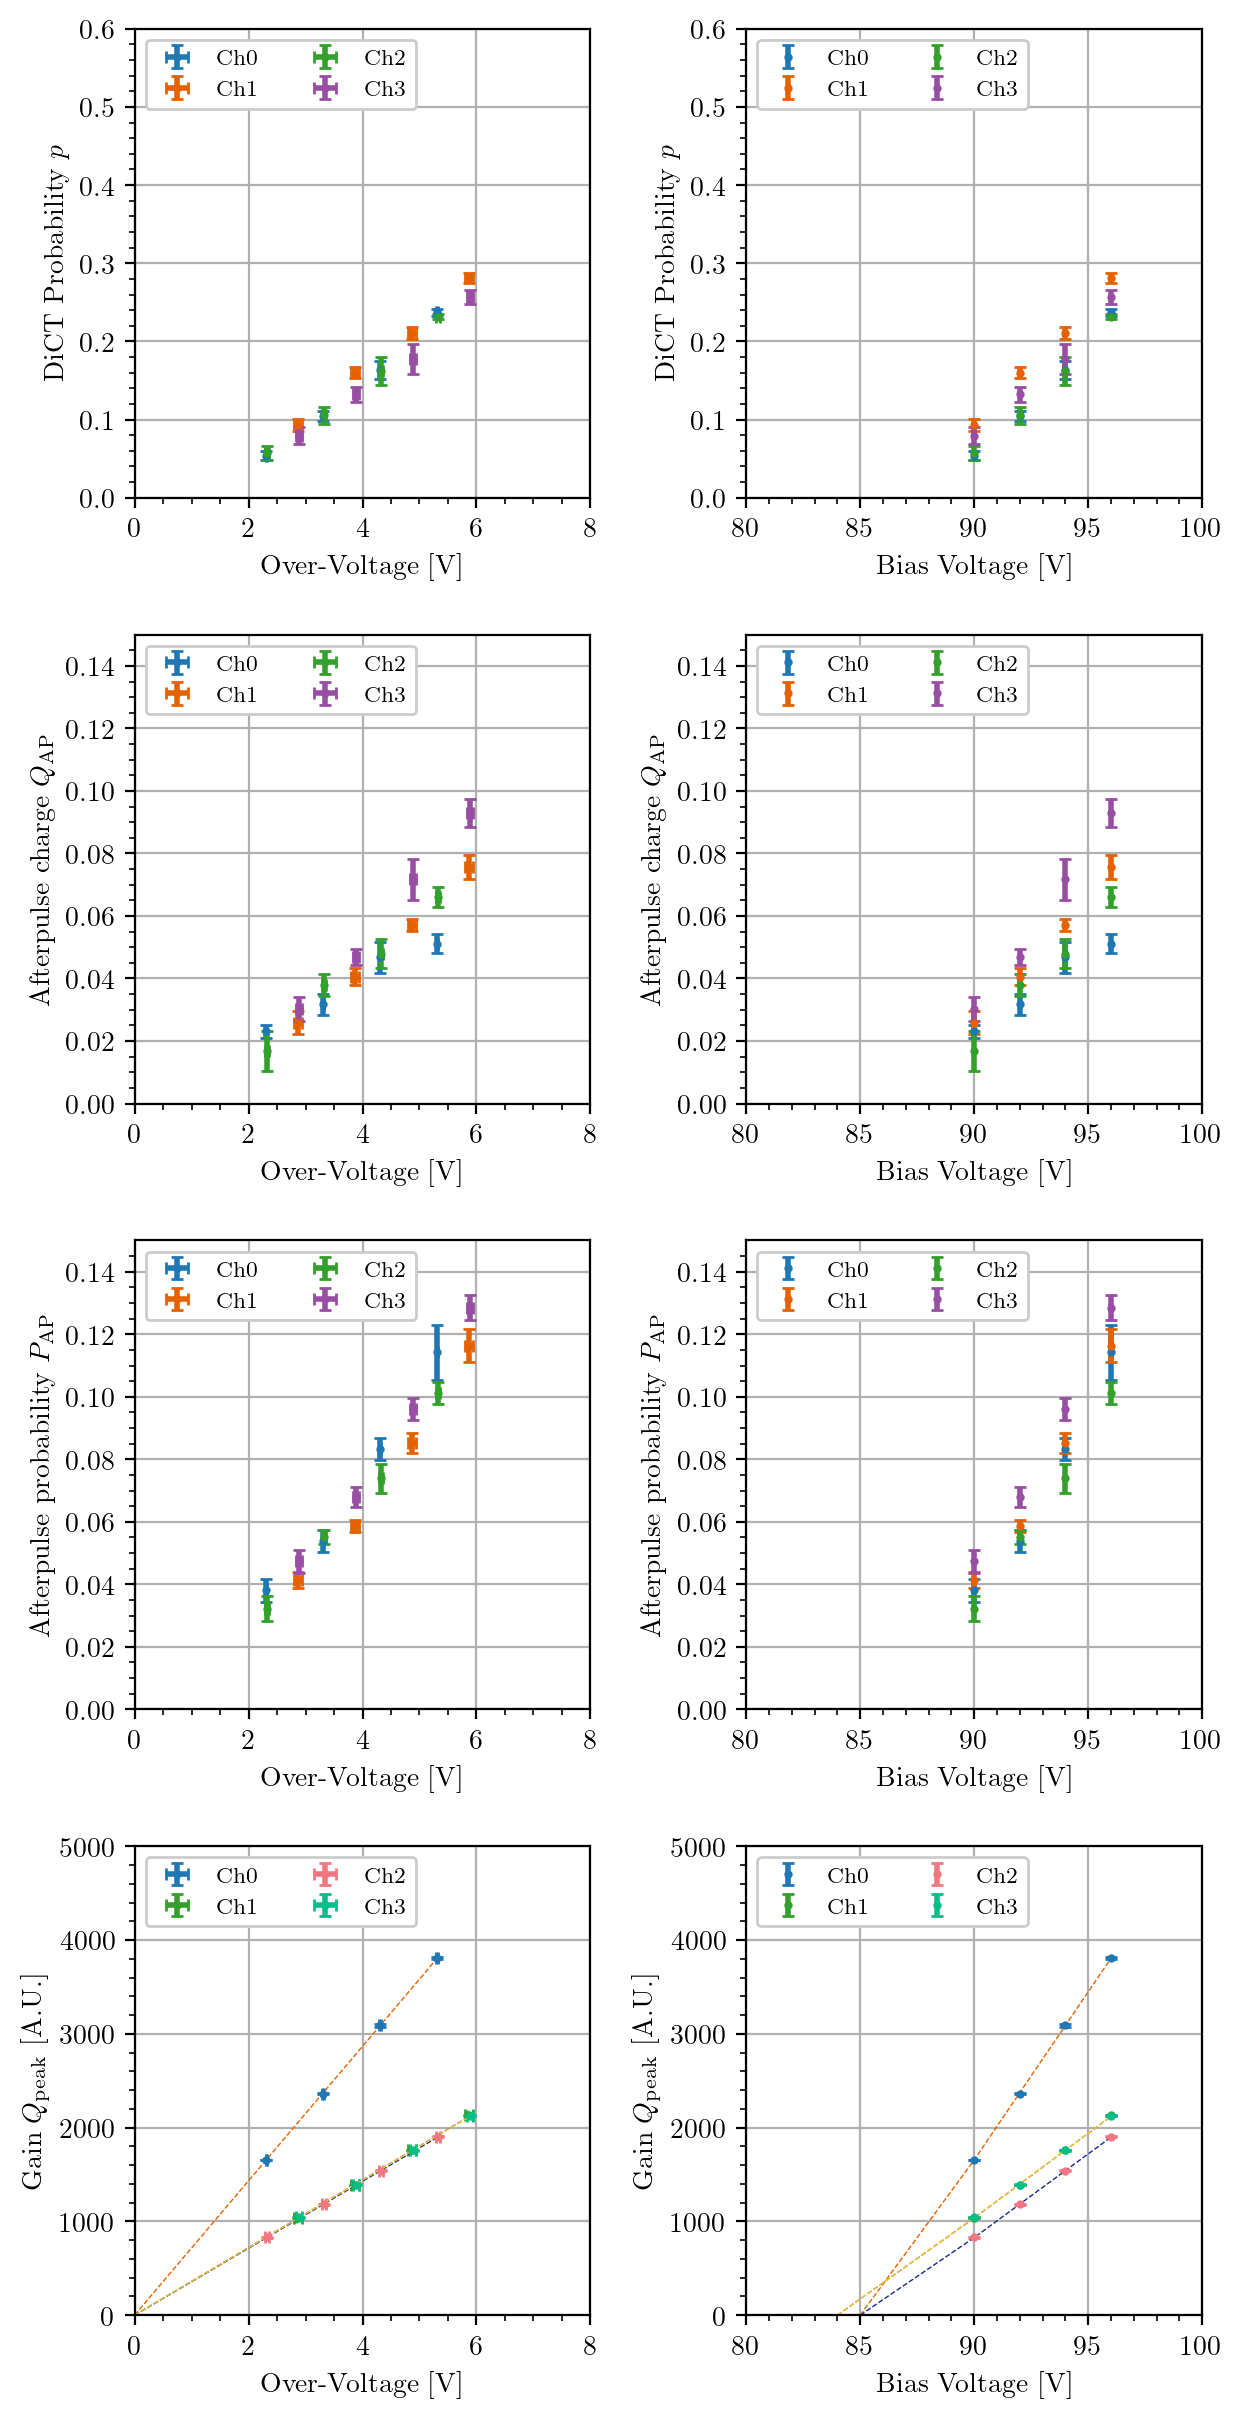

In [ ]:
# Make summary plots
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

x_keys = ['ov','bias']
y_keys = ['dict','ap_charge', 'ap_prob', 'gain']
fig, axs = plt.subplots(len(y_keys),len(x_keys))
fig.set_size_inches(len(x_keys)*3, len(y_keys)*3)
fig.tight_layout(h_pad=3, w_pad=3)

for i,yk in enumerate(y_keys):
    for j,xk in enumerate(x_keys):
        for intn in intensities:
            for ch in channels:
                if xk=='ov':
                    axs[i,j].errorbar(
                        results[yk][intn][ch][xk],
                        results[yk][intn][ch][yk],
                        xerr=results[yk][intn][ch][f'{xk}_err'],
                        yerr=results[yk][intn][ch][f'{yk}_err'],
                        label=f'Ch{ch}',
                        fmt='o',
                        markersize=2)
                elif xk=='bias':
                    axs[i,j].errorbar(
                        results[yk][intn][ch][xk],
                        results[yk][intn][ch][yk],
                        yerr=results[yk][intn][ch][f'{yk}_err'],
                        label=f'Ch{ch}',
                        fmt='o',
                        markersize=2)
                if yk=='gain':
                    if xk=='ov':
                        axs[i,j].plot(
                            np.insert(results['gain'][intn][ch]['ov'],0,0),
                            np.insert(results['gain'][intn][ch]['ov']*vbd_fits[intn][ch]['par'][0]*2,0,0),
                            '--',
                            linewidth=0.5)
                    elif xk=='bias':
                        axs[i,j].plot(
                            np.insert(results['gain'][intn][ch]['bias'],0,vbd_fits[intn][ch]['vbd']),
                            np.insert((results['gain'][intn][ch]['bias']-vbd_fits[intn][ch]['vbd'])*vbd_fits[intn][ch]['par'][0],0,0),
                            '--',
                            linewidth=0.5)
        axs[i,j].legend(ncol=2)
        if j==0:
            axs[i,j].set_xlabel(r'Over-Voltage [V]')
            axs[i,j].set_xlim(0, 8)
        else:
            axs[i,j].set_xlabel(r'Bias Voltage [V]')
            axs[i,j].set_xlim(80, 100)
        if i==0:
            axs[i,j].set_ylabel(r'DiCT Probability $p$')
            axs[i,j].set_ylim(0, 0.6)
        elif i==1:
            axs[i,j].set_ylabel(r'Afterpulse charge $Q_{\rm AP}$')
            axs[i,j].set_ylim(0, 0.15)
        elif i==2:
            axs[i,j].set_ylabel(r'Afterpulse probability $P_{\rm AP}$')
            axs[i,j].set_ylim(0, 0.15)
        elif i==3:
            axs[i,j].set_ylabel(r'Gain $Q_{\rm peak}$ [A.U.]')
            axs[i,j].set_ylim(0, 5e3)
        axs[i,j].grid()
        axs[i,j].minorticks_on()

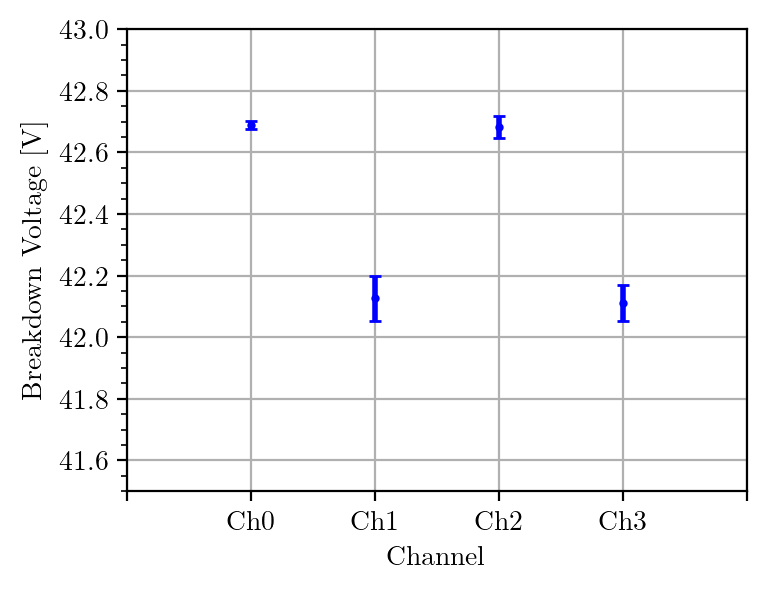

In [ ]:
# Vbd-channel
fig, ax = plt.subplots()
channel_labels = []
for intn in intensities:
    for ch in channels:
        plt.errorbar(
            [ch], 
            [results['vbd'][intn][ch]['vbd_sipm']],
            yerr=[results['vbd'][intn][ch]['vbd_sipm_err']],
            fmt='bo', markersize=2)
        channel_labels.append(f'Ch{ch}')
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage [V]')
ax.xaxis.set(ticks=np.arange(len(channels)), ticklabels=channel_labels)
plt.xlim(-1, 4)
plt.ylim(41.5, 43)
plt.grid()
plt.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_tick_params(which='minor', bottom=False)
plt.show()

In [ ]:
# Analyze Vbd distribution
vbd_array = []
vbd_err_array = []
for intn in intensities:
    for ch in channels:
        vbd_array.append(results['vbd'][intn][ch]['vbd_sipm'])
        vbd_err_array.append(results['vbd'][intn][ch]['vbd_sipm_err'])
vbd_array = np.array(vbd_array)
vbd_err_array = np.array(vbd_err_array)
vbd_avg = np.average(vbd_array, weights=1/vbd_err_array**2)
vbd_stat = np.sum(vbd_err_array**(-2))**(-0.5)
print('Breakdown voltage per SiPM = {:.2f}+/-{:.2f}(stat) V'.format(vbd_avg, vbd_stat))
vbd_rms = np.std(vbd_array, ddof=1)
print('RMS variation = {:.2f}V'.format(vbd_rms))

Breakdown voltage per SiPM = 42.65+/-0.01(stat) V
RMS variation = 0.33V


# Write to HDF5 file

In [ ]:
h5filename = f'data/calibration_liq4_2023-07-12.h5'
columns = ['channel', 'A1min', 'A1max', 'DiCT', 'DiCT_err', 'Qavg', 'Qavg_err', 'Qpeak', 'Qpeak_err', 'Qap', 'Qap_err', 'bsl_rms']
for intn in intensities:
    for volt in voltages:
        store = pd.HDFStore(h5filename)
        store.put(f'{intn}/{volt}V',pd.DataFrame(np.array([[
            ch,
            amp_hist[intn][ch][volt]['boundaries'][1],
            amp_hist[intn][ch][volt]['boundaries'][2],
            crosstalk[intn][ch][volt]['dict'],
            crosstalk[intn][ch][volt]['dict_err'],
            gain_avg_fits[intn][ch][volt]['Qavg'],
            gain_avg_fits[intn][ch][volt]['Qavg_err'],
            gain_peak_fits[intn][ch][volt]['Qpeak'],
            gain_peak_fits[intn][ch][volt]['Qpeak_err'],
            ap_charge[intn][ch][volt]['Qap'],
            ap_charge[intn][ch][volt]['Qap_err'],
            mybsl[intn][ch][volt]['rms_threshold']
        ] for ch in channels]), columns=columns).astype({'channel':'int'}))
        store.close()

In [ ]:
for intn in intensities:
    for volt in voltages:
        summary = pd.read_hdf('data/calibration_liq4_2023-07-12.h5', key=f'/{intn}/{volt}V')
        print(f'{intn} {volt}V')
        print(summary)

1070 90V
   channel   A1min   A1max      DiCT  DiCT_err         Qavg  Qavg_err  \
0        0  184.75  575.25  0.053596  0.005510  1696.039383  3.425773   
1        1  146.25  404.75  0.092891  0.007938  1070.780714  3.143333   
2        2   99.50  289.25  0.057344  0.008808   845.863698  4.103878   
3        3  140.75  435.00  0.079024  0.010832  1077.021974  3.162280   

         Qpeak  Qpeak_err       Qap   Qap_err  bsl_rms  
0  1655.732108   1.021794  0.023039  0.002048      2.0  
1  1041.079464   2.550788  0.025879  0.003567      6.5  
2   830.967987   3.792865  0.016898  0.006392      1.5  
3  1042.735308   2.976519  0.030283  0.003895      1.5  
1070 92V
   channel   A1min   A1max      DiCT  DiCT_err         Qavg  Qavg_err  \
0        0  278.25  858.50  0.104476  0.006003  2445.842947  1.572097   
1        1  190.25  545.00  0.159764  0.006912  1456.064920  3.151597   
2        2  143.50  429.50  0.105291  0.010528  1230.711061  3.636084   
3        3  195.75  597.25  0.132120  0

## Calculate rENF versus bias/over-voltage

Following https://ieeexplore.ieee.org/document/5402300 closely, the reduced excess noise factor (rENF) here is defined as
$$\mathrm{rENF}(V_{\rm bias})=\frac{1+p_{\rm DiCT}(V_{\rm bias})}{\mu(V_{\rm bias})/\mu(63V)},$$
where $p_{\rm DiCT}$ is the DiCT probability, and $\mu$ is the parameter obtained from the Vinogradov fits.
Since the laser intensity did not change when taking data at different voltages, $\mu$ is the relative PDE. We choose $V_{\rm bias}=63V$ as the reference point.


In [ ]:
results['renf'] = {}
for intn in intensities:
    results['renf'][intn] = {}
    for ch in channels:
        results['renf'][intn][ch] = {}
        results['renf'][intn][ch]['bias'] = np.array(voltages)
        results['renf'][intn][ch]['ov'] = results['renf'][intn][ch]['bias']/nsipms-results['vbd'][intn][ch]['vbd_sipm']
        results['renf'][intn][ch]['ov_err'] = np.ones(results['renf'][intn][ch]['ov'].shape[0])*results['vbd'][intn][ch]['vbd_sipm_err']
        results['renf'][intn][ch]['renf'] = np.array([(1+crosstalk[intn][ch][volt]['par'][1])/(crosstalk[intn][ch][volt]['par'][0]/crosstalk[intn][ch][voltages[0]]['par'][0]) for volt in voltages])
        results['renf'][intn][ch]['renf_err'] = results['renf'][intn][ch]['renf']*np.array([ ( crosstalk[intn][ch][volt]['cov'][0,0]/(crosstalk[intn][ch][volt]['par'][0])**2 + crosstalk[intn][ch][volt]['cov'][1,1]/(1+crosstalk[intn][ch][volt]['par'][1])**2 )**0.5 for volt in voltages])


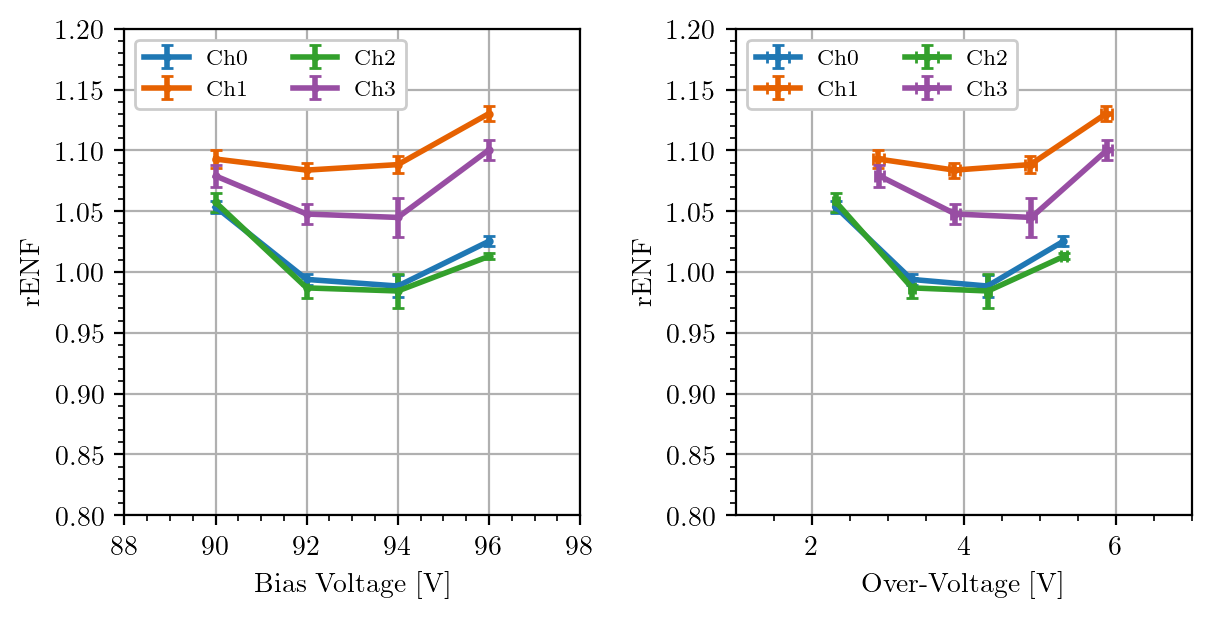

In [ ]:
# Relative PDE: the mu parameter from the DiCT fits
fig, axs = plt.subplots(1,2)
fig.set_size_inches(6, 3)
fig.tight_layout(h_pad=3, w_pad=3)
intn = 1070
for ch in channels:
    axs[0].errorbar(
        results['renf'][intn][ch]['bias'],
        results['renf'][intn][ch]['renf'],
        yerr=results['renf'][intn][ch]['renf_err'],
        label=f'Ch{ch}',
        fmt='C{}o-'.format(ch),
        markersize=2)
    axs[1].errorbar(
        results['renf'][intn][ch]['ov'],
        results['renf'][intn][ch]['renf'],
        xerr=results['renf'][intn][ch]['ov_err'],
        yerr=results['renf'][intn][ch]['renf_err'],
        label=f'Ch{ch}',
        fmt='C{}o-'.format(ch),
        markersize=2)
for i in [0,1]:
    if i==0:
        axs[i].set_xlabel('Bias Voltage [V]')
        axs[i].set_xlim(88, 98)
    else:
        axs[i].set_xlabel('Over-Voltage [V]')
        axs[i].set_xlim(1, 7)

    axs[i].set_ylabel('rENF')
    axs[i].legend(ncol=2)
    axs[i].grid()
    axs[i].minorticks_on()
    axs[i].set_ylim(0.8,1.20)
    